# Recommendations Systems
## Final project:  [Session-based recommendations with recurrent neural networks](https://arxiv.org/pdf/1511.06939)

**By:**  

Gil Zeevi, 203909320  
Gil Ayache, 200358612

**Group 25:**
<br><br>

-----------------------

## Disclaimer about copyrights:
this work has been made as part of a final project in a recommendation system course in reichman university.<br>
the course was led by Dr Asi Messica and Sahar Millis<br>
hence, the following materials were used solely for academical porpuses, with no commercial intentions whatsoever.<br>
we do not own the data, and downloaded it from [Kaggle](https://www.kaggle.com/chadgostopp/recsys-challenge-2015).<br>
We thank the following people for enabling us to extand our knowledge by sharing their work as an open source through github.<br>
We've based our code on their work and thus we offer new insights and small innovations.
<br>

**Our work is based and inspired from the authors of the GRU4REC following papers and their git repo:**
https://github.com/hidasib/GRU4Rec
<br><br>
furthermore,  Balázs Hidasi states to cite the following when using his code for educational purposes:

© Copyright 2015-2020, Balázs Hidasi and Gravity Research & Development Zrt. All rights reserved.

[1] Balázs Hidasi, Alexandros Karatzoglou, Linas Baltrunas, Domonkos Tikk: Session-based Recommendations with Recurrent Neural Networks. arXiv preprint arXiv:1511.06939, 2015. https://arxiv.org/abs/1511.06939 Presented at the 4th International Conference on Learning Representations, ICLR 2016.

[2] Balázs Hidasi, Alexandros Karatzoglou: Recurrent Neural Networks with Top-k Gains for Session-based Recommendations. arXiv preprint arXiv:1706.03847, 2017. https://arxiv.org/abs/1706.03847

**For the GRU part which was implemented with pytorch, we cloned,revised and adapted relevent parts out of it, solely for academic porpusesm from the work of Phạm Thanh Hùng(hungthanhpham94) and Younghun Song (yhs-968):**
- [Phạm Thanh Hùng(hungthanhpham94) repo](https://github.com/hungthanhpham94/GRU4REC-pytorch)
- [Younghun Song (yhs-968) repo](https://github.com/yhs968/pyGRU4REC)


-----------------------

# Chosen Dataset: <u> YOOCHOOSE - RecSys Challenge 2015</u> 
<u>general explaination on the dataset:</u><br>
The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session<br>
is encapsulating the click events that the user performed in the session.<br>
For some of the sessions, there are also buy events; means that the session ended with the user bought something from the web shop.<br> The data was collected during several
months in the year of 2014, reflecting the clicks and purchases performed by the users of an on-line retailer in Europe.<br>
**We thus conclude that the dataset represents an implicit recommender system challange due to a binary representations of the data - clicked or not, bought or not.**<br>
The dataset is composed out of 3 files (and a readme as well):
 - yoochoose-buys.dat , ~55MB
 - yoochoose-clicks.dat, ~1.5GB
 - yoochoose-test.dat,  ~363 MB
 
<br>**The authors of the original paper ignored the testset and just splitted yoochoose-clicks.dat into train and test datasets.
in order to maintain consistency and to try and recreate the authors results, we will do the same**

#### <u>CLICKS DATASET FILE DESCRIPTION</u>

The file yoochoose-clicks.dat comprising the clicks of the users over the items.<br>
Each record/line in the file has the following fields/format: Session ID, Timestamp, Item ID, Category<br>
-Session ID – the id of the session. In one session there are one or many clicks. Could be represented as an integer number.<br>
-Timestamp – the time when the click occurred. Format of YYYY-MM-DDThh:mm:ss.SSSZ<br>
-Item ID – the unique identifier of the item that has been clicked. Could be represented as an integer number.<br>
-Category – the context of the click. The value "S" indicates a special offer, "0" indicates  a missing value, a number between 1 to 12 indicates a real category identifier,<br>
 any other number indicates a brand. E.g. if an item has been clicked in the context of a promotion or special offer then the value will be "S", if the context was a brand i.e BOSCH,<br>
 then the value will be an 8-10 digits number. If the item has been clicked under regular category, i.e. sport, then the value will be a number between 1 to 12. <br>
 
* The explanation above is based on the README.txt attached to the dataset.<br>
    This dataset is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0
    International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc-nd/4.0/

### Smaller Sample: 4.5 days of sessions,
We've decided to use a smaller dataset in order to be able to train different variations of GRU network at home-made scale.
we've used simultaneously resourses of local GPU, colab PRO, and Kaggle provided GPU and trained many networks in order to conclude some interesting findings
we've used 4.5 days of sessions as a complete dataframe. 
this data was splitted as follows:
 - **train** dataset: 3.5 days of sessions
 - **test** dataset: 0.5 days of sessions
 - **validation** dataset: 0.5 days of sessions
we used the notebook YOOCHOOSE_preprocessing.ipynb in order to preprocess data and thus not maintaining 'thinner' notebook.
we did favor notebook over .py files due to visualizations advantage of notebooks over module files

-----------------------

# Loading processed train and test datasets:

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import dill
import argparse
import torch
import lib
import os
import warnings
warnings.filterwarnings('ignore')

# pd.options.display.float_format = '{:.5f}'.format


In [160]:
%%time
train = pd.read_csv('data/train_samp_tr.txt', sep=',')
test = pd.read_csv('data/test_samp.txt', sep=',')
valid  =   pd.read_csv('data/train_samp_valid.txt', sep=',')


Wall time: 731 ms


In [161]:
print('Sampled train set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(train), train['SessionID'].nunique(), train['ItemID'].nunique()))
print('Sampled Test set set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(test), test['SessionID'].nunique(), test['ItemID'].nunique()))
print('Validation set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(valid), valid['SessionID'].nunique(), valid['ItemID'].nunique()))

Sampled train set
	Events: 732685
	Sessions: 179756
	Items: 18101
Sampled Test set set
	Events: 88521
	Sessions: 21329
	Items: 9168
Validation set
	Events: 75756
	Sessions: 17948
	Items: 8897


### Lets present some EDA on the sessions dataset:

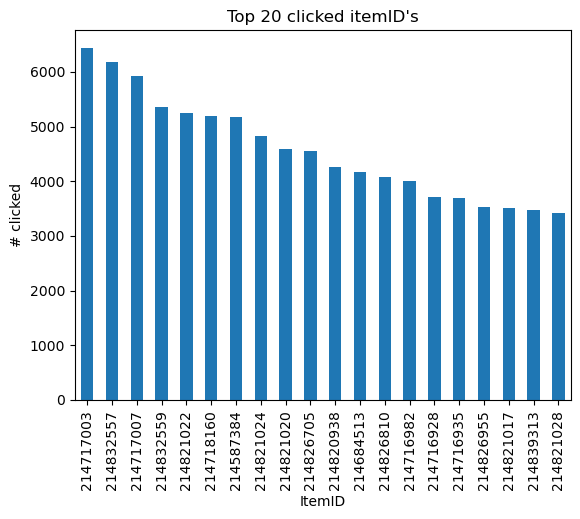

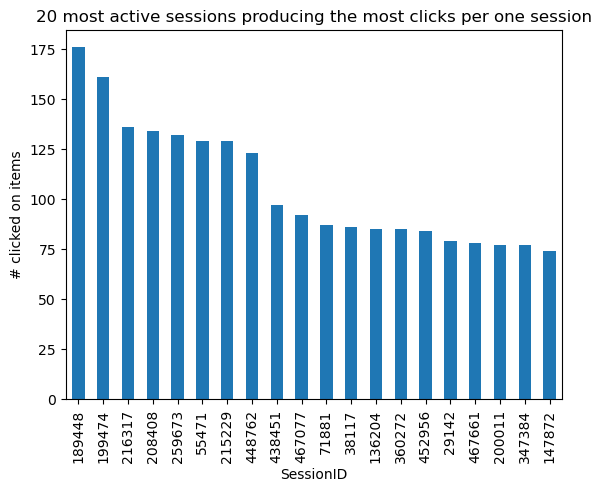

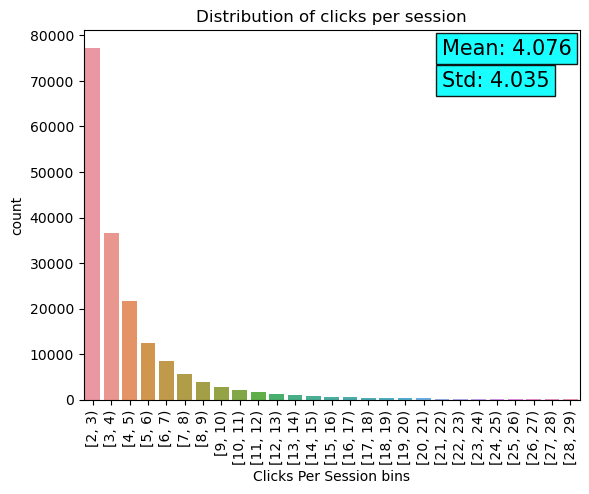

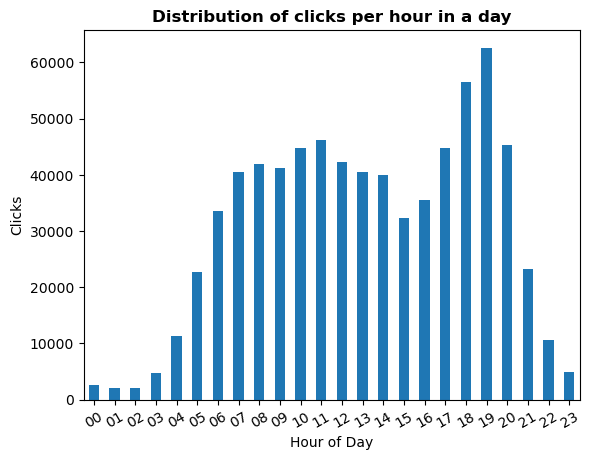

In [162]:
#Top 20 clicked items:

train.groupby('ItemID').size().nlargest(20).plot(kind='bar')
plt.ylabel('# clicked')
plt.title("Top 20 clicked itemID's")
plt.show()

#Top 20 hottest sessions - most clicks:
train.groupby('SessionID').size().nlargest(20).plot(kind='bar')
plt.title("20 most active sessions producing the most clicks per one session")
plt.ylabel('# clicked on items')
# plt.axis('off')
plt.show()

#distribution of Clicks per session
fig, axes = plt.subplots(1,1)
bins = list(range(2, 30, 1))
sessionscount = train.set_index('SessionID').groupby('SessionID').size()
catdf = pd.DataFrame({'clicks per session': sessionscount, 
                        'Clicks Per Session bins': pd.cut(sessionscount, bins=bins, right=False)})
hs = sns.countplot(data=catdf, x='Clicks Per Session bins',ax=axes)
x_min,x_max=hs.get_xlim()
y_min,y_max=hs.get_ylim()
hs.text(x_min+19.5, y_max-y_max/6.55,f'Std: {np.round(catdf.std()[0],4)}' ,color='black',size=15, bbox=dict(facecolor='cyan', alpha=0.9))
hs.text(x_min+19.5, y_max-y_max/15,f'Mean: {np.round(catdf.mean()[0],4)}' ,color='black',size=15, bbox=dict(facecolor='cyan', alpha=0.9))
hs.tick_params(axis='x', labelrotation=90)
hs.set_title("Distribution of clicks per session")
# plt.axis('off')
plt.show()

#distribution of Clicks per hour
timedf = train.copy()
timedf['Time'] = timedf['Time'].apply(lambda x: dt.datetime.fromtimestamp(x).strftime('%H'))
timedf.groupby('Time').size().plot(kind='bar')
plt.title("Distribution of clicks per hour in a day",weight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Clicks')
plt.tick_params(axis='x', labelrotation=30)
plt.show()


# Now the real fun begins! building recommender models!

### Creating the <u>classical Popularity model</u> which Recommend the most popular items

The Popularity model gives higher scores to items with larger occurances, denoted by:<br><br>
$$ r_{i}=\ \frac{occur_i}{(1+occur_i)} $$

In [ ]:
class POP():

    def __init__(self,df_train,top_n = 100):
    # df is the set to train on
    # top_n is the number of top ranked number for whom we return scores
        self.df_train = df_train
        self.top_n = top_n 
        self.pop_model = None
        self.fit_time = 0
        self.recall=0
        self.mrr = 0

    def fit(self):
        t = time.time() #recording fit time
        occur = self.df_train.groupby(['ItemID']).size()
        self.pop_model = (occur/(1+occur)).sort_values(ascending=False) #apply popularity model
        self.pop_model = self.pop_model.head(self.top_n) #truncate the recommendations only to top_n recommendations
        self.fit_time = time.time() - t
        
    def predict(self,session_id,item_id,set_of_ids):
        '''
        input: IDs of items for which the recommender should give prediction scores. list/np.array
        output: pd.Series of items ID and corresponding prediction score based on popularity model
        '''
        if type(set_of_ids)==type([]):
            set_of_ids = np.array(set_of_ids)    
        pred = np.zeros(len(set_of_ids))
        mask = np.in1d(set_of_ids, self.pop_model.index)
        pred[mask] = self.pop_model[set_of_ids[mask]]
        return pd.Series(pred,set_of_ids)
        

### Creating a <u>Popularity model per Session</u> which Recommends the most popular items of the current session
this model is a little bit more sophisticated than the classic baseline because the recommendation list changes during the session as items gain more events.<br>
Another interesting thing that the authros applied here is a tie-breaking mechanism.<br> Ties are broken by using the scores from the classical popularity model.<br>
The formula is denoted respectively as follows::<br><br>
$$r_{s,i} = occur_{s,i} + \ \frac{occur_i}{(1+occur_i)}$$

In [ ]:
class S_POP():

    def __init__(self,df_train,top_n = 100):
    # df is the set to train on
    # top_n is the number of top ranked number for whom we return scores
        self.df_train = df_train
        self.top_n = top_n 
        self.spop_model = None
        self.fit_time = 0
        self.prev_session_id = -1
        self.recall=0
        self.mrr = 0

    def fit(self):
        #same as classic popularity model
        t = time.time() #recording fit time
        occur = self.df_train.groupby(['ItemID']).size()
        self.spop_model = (occur/(1+occur)).sort_values(ascending=False) #apply popularity model
        self.spop_model = self.spop_model.head(self.top_n) #truncate the recommendations only to top_n recommendations
        self.fit_time = time.time() - t
        
               
    def predict(self,session_id,item_id,set_of_ids):
        '''
        input:
            - session_id: the session id of current event
            - item_id: the item id of the chosen current event
            - set_of_ids : IDs of items for which the recommender should give prediction scores. list/np.array
            
        output: pd.Series of items ID and corresponding prediction score based on popularity model
        '''
        if type(set_of_ids)==type([]):
            set_of_ids = np.array(set_of_ids) 
        #predict as in the classic popularity model:
        
        pred = np.zeros(len(set_of_ids))
        mask = np.in1d(set_of_ids, self.spop_model.index)
        pred[mask] = self.spop_model[set_of_ids[mask]]
    
        #Now for breaking ties, add occurances based on session and item
        if self.prev_session_id != session_id:
            self.prev_session_id = session_id
            self.occurs = dict()
        #creating a dictionary of global occurances
        
        v = self.occurs.get(item_id)
        if v:
            self.occurs[item_id] = v + 1
        else:
            self.occurs[item_id] = 1
            
        occur = pd.Series(self.occurs)
        mask = np.in1d(set_of_ids, occur.index)
        pred[mask] += occur[set_of_ids[mask]]
        
        return pd.Series(pred,set_of_ids)
        

### Creating an <u>Item-KNN recommender</u> which Recommends N Items similar to a given item
This model is one of the most common and succesful item-to-item solutions in collaborative filtering.
put in simple words, the logic behind it is that people who looked into a specific items, looked also on a following specific set of items.<br>
it is denoted by the following formula:

$$s_{i,j}\ \ =\ \  \frac{\sum_{s}I\{(s,i)\in D \cap (s,j)\in D\}}{\sqrt{(occur_i+\ \lambda)\cdot(occur_j+\ \lambda)}}$$


$I \ - Similarity \ \ notation\\i,j \ - items \\s \ - Session \\D \ - Dataset \\ \lambda \ - Regularization \ \ term$

And in plain words it means, sum of all **co-occurrences** of two items $i,j$ which is represented as $I$ which symbolizes *Similarity*.<br>
it is then divided by the squreroot of each item total of occurances in all sessions with and addition of regularization $\lambda$.<br>
it is included to avoid coincidental high similarities of rarely visited items.

In [ ]:
class ItemKNN():

    def __init__(self,df_train,top_n = 100, lmbd = 20):
        self.lmbd = lmbd
        self.df_train = df_train.reset_index(drop=True)
        self.top_n = top_n 
        self.fit_time = 0
        self.sim_item ={}
        self.recall=0
        self.mrr = 0
        
    def fit(self):
        t = time.time() #recording fit time
             

        # prepare item occurances column by item index
        
        itemids = self.df_train['ItemID'].unique()
        n_items = len(itemids) 
        self.df_train = pd.merge(self.df_train, pd.DataFrame({'ItemID':itemids, 'ItemIdx':np.arange(len(itemids))}), on='ItemID', how='inner')
        # prepare session occurances column by session index
        
        sessionids = self.df_train['SessionID'].unique()
        self.df_train = pd.merge(self.df_train, pd.DataFrame({'SessionID':sessionids, 'SessionIdx':np.arange(len(sessionids))}), on='SessionID', how='inner')
        
        # get the cumulative count of sessions ordered
        occur = self.df_train.groupby('SessionIdx').size()
        session_offsets = np.zeros(len(occur)+1, dtype=np.int32)
        session_offsets[1:] = occur.cumsum()
        index_by_sessions = self.df_train.sort_values(['SessionIdx', 'Time']).index.values
        
        # get the cumulative count of items ordered
        occur = self.df_train.groupby('ItemIdx').size()
        item_offsets = np.zeros(n_items+1, dtype=np.int32)
        item_offsets[1:] = occur.cumsum()
        index_by_items = self.df_train.sort_values(['ItemIdx', 'Time']).index.values
        
        #Start Fitting
        
        for i in range(n_items):
            iarray = np.zeros(n_items)
            start = item_offsets[i]
            end = item_offsets[i+1]
            for e in index_by_items[start:end]:
                uidx = self.df_train.SessionIdx.values[e]
                ustart = session_offsets[uidx]
                uend = session_offsets[uidx+1]
                user_events = index_by_sessions[ustart:uend]
                iarray[self.df_train.ItemIdx.values[user_events]] += 1
            iarray[i] = 0
            norm = ((occur[i] + self.lmbd)**0.5) * ((occur.values + self.lmbd)**0.5)
            norm[norm == 0] = 1
            iarray = iarray / norm
            indices = np.argsort(iarray)[-1:-1-self.top_n:-1]
            self.sim_item[itemids[i]] = pd.Series(iarray[indices], itemids[indices])

        
        self.fit_time = time.time() - t
                                           
    def predict(self,session_id,item_id,set_of_ids):
        
        '''
        input:
            - item_id: the item id of the chosen current event
            - set_of_ids : IDs of items for which the recommender should give prediction scores. list/np.array
            
        output: pd.Series of items ID and corresponding prediction score based on popularity model
        '''
        if type(set_of_ids)==type([]):
            set_of_ids = np.array(set_of_ids) 
        pred = np.zeros(len(set_of_ids))
        sim_list = self.sim_item[item_id]
        mask = np.in1d(set_of_ids, sim_list.index)
        pred[mask] = sim_list[set_of_ids[mask]]
        return pd.Series(pred,set_of_ids)

### Creating a <u>BPR - MF recommender</u> which is a  matrix factorization method that uses pairwise ranking loss
This model is a common model from the matrix factorization family. it optimizes a pairwise ranking loss, using Stochastic Gradient Descent.<br>
To apply this method on sessions-based problems, the current state of the session is modeled as the average of the feature vectors of the items that have occurred in it so far.<br>
the similarites of the feature vectors between a recommendable item and the items of the session so far are being averaged.


The loss which is being optimized is denoted as the following:

$$L_{s}\ \ =\ \ -\frac{1}{N_s} \cdot \sum_{j=1}^{N_s} log\ ({\large \sigma}\ (r_{s,i} - r_{s,j} )) $$


$N_s \ - Sample \ Size \\r_{s,i} \ - Score \ on \ item \ i\ (or\ negative\ sampling\ j\ ) \ at \ the\ given\ point\ of\ session\  \ \\{\large \sigma} \ - Sigmoid\ Function \ \frac{1}{1+e^{-x}}$

In [ ]:
class BPR_MF():
    
    def __init__(self,df_train,n_factors = 100,sigma=0.05):
        self.df_train = df_train
        self.n_factors = n_factors
        self.sigma = sigma
        self.fit_time = 0
        self.n_items = len(df_train['ItemID'].unique())
        self.n_sessions = len(df_train['SessionID'].unique())
        self.loss = []
        self.l_history = []
        self.current_session = None
        self.recall=0
        self.mrr = 0
        
        # reset initialization 
        self.initialize_params()

        
        
    def initialize_params(self):
        #initialize data
        itemids = self.df_train['ItemID'].unique()
        self.itemidmap = pd.Series(data=np.arange(self.n_items), index=itemids)
        sessionids = self.df_train['SessionID'].unique()
        data = pd.merge(self.df_train, pd.DataFrame({'ItemID':itemids,
                                            'ItemIdx':np.arange(self.n_items)}),
                        on='ItemID', how='inner')
        self.data = pd.merge(data, pd.DataFrame({'SessionID':sessionids,
                                            'SessionIdx':np.arange(self.n_sessions)}),
                        on='SessionID', how='inner')    
        
        #initialize latent features
        self.U = np.random.randn(self.n_sessions, self.n_factors) * self.sigma
        self.I = np.random.randn(self.n_items, self.n_factors) * self.sigma
        
        #initialize bias
        self.bU = np.zeros(self.n_sessions)
        self.bI = np.zeros(self.n_items)
        
        
    def optim_SGD(self):
        tmp = []
        for e in tqdm(np.random.permutation(len(self.data))):
            #get values to update in SGD
            
            uidx = self.data.SessionIdx.values[e]
            p = self.data.ItemIdx.values[e]
            n = self.data.ItemIdx.values[np.random.randint(self.n_items)]
            #Perform update

            uF = np.copy(self.U[uidx,:])
            iF1 = np.copy(self.I[p,:])
            iF2 = np.copy(self.I[n,:])
            sigm = self.sigmoid(iF1.T.dot(uF) - iF2.T.dot(uF) + self.bI[p] - self.bI[n])
            c = 1.0 - sigm
            self.U[uidx,:] += self.learning_rate * (c * (iF1 - iF2) - self.lambda_session * uF)
            self.I[p,:] += self.learning_rate * (c * uF - self.lambda_item * iF1)
            self.I[n,:] += self.learning_rate * (-c * uF - self.lambda_item * iF2)
            tmp.append(np.log(sigm)) 
            
        self.loss.append(np.mean(tmp))
        self.l_history.extend(tmp)
        
        
    def fit(self,n_iterations = 10,
            learning_rate = 0.01,
            lambda_session = 0.0,
            lambda_item = 0.0,
           ):

        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.lambda_session = lambda_session 
        self.lambda_item = lambda_item
        
        t = time.time() #recording fit time
        
        for it in tqdm(range(self.n_iterations)):
            self.optim_SGD()


        
        self.fit_time = time.time() - t
                                           
    def predict(self,session_id,item_id,set_of_ids):
        '''
        input:
            - session_id: the session id of current event
            - item_id: the item id of the chosen current event
            - set_of_ids : IDs of items for which the recommender should give prediction scores. list/np.array
            
        output: pd.Series of items ID and corresponding prediction score, indexed by item IDs
        '''
        iidx = self.itemidmap[item_id]
        if self.current_session is None or self.current_session != session_id:
            self.current_session = session_id
            self.session = [iidx]
        else:
            self.session.append(iidx)
            
        uF = self.I[self.session].mean(axis=0)
        iIdxs = self.itemidmap[set_of_ids]
        return pd.Series(self.I[iIdxs].dot(uF) + self.bI[iIdxs], set_of_ids)
    
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

In [ ]:
def evaluate_sessions(model, test_data, train_data, items=None, cut_off=20, session_key='SessionID', item_key='ItemID', time_key='Time'):    
    '''
    Evaluate the MRR and recall of a given model
    
    returns:
    recall, mrr
    based on @author: Balázs Hidasi implementation
    
    '''
    test_data.sort_values([session_key, time_key], inplace=True)
    items_to_predict = train_data[item_key].unique()
    evalutation_point_count = 0
    prev_iid, prev_sid = -1, -1
    mrr, recall= 0.0, 0.0
    print('Evaluating...')
    for i in tqdm(range(len(test_data))):
        sid = test_data[session_key].values[i]
        iid = test_data[item_key].values[i]
        if prev_sid != sid:
            prev_sid = sid
        else:
            if items is not None:
                if np.in1d(iid, items): items_to_predict = items
                else: items_to_predict = np.hstack(([iid], items))
            preds = model.predict(sid, prev_iid, items_to_predict)
            preds[np.isnan(preds)] = 0
            preds += 1e-8 * np.random.rand(len(preds)) #Breaking up ties
            rank = (preds > preds[iid]).sum()+1
            assert rank > 0
            if rank < cut_off:
                recall += 1
                mrr += 1.0/rank
            evalutation_point_count += 1
        prev_iid = iid
                
    model.recall = recall/evalutation_point_count
    model.mrr = mrr/evalutation_point_count
    return preds,iid,rank

## Fit and Evaluate all baseline models
Now after building the models, we can fit and then evaluate MRR and Recall as presented in the paper.<br>
We will save our fitting objects with dill (dill extends python's pickle module for serializing and de-serializing python objects) and reload when necessary.

In [ ]:
pop = POP(train)
pop.fit()
evaluate_sessions(pop, test, train, items=None, cut_off=20, session_key='SessionID', item_key='ItemID', time_key='Time')
print(f"Recall = {pop.recall}\n MRR = {pop.mrr}\n")
dill.dump(pop, file = open("pop_sample.pickle", "wb"))

In [ ]:
spop = S_POP(train)
spop.fit()
evaluate_sessions(spop, test, train, items=None, cut_off=20, session_key='SessionID', item_key='ItemID', time_key='Time')
print(f"Recall = {spop.recall}\n MRR = {spop.mrr}\n")
dill.dump(spop, file = open("spop_sample.pickle", "wb"))

In [ ]:
itemknn = ItemKNN(train)
itemknn.fit()
evaluate_sessions(itemknn, test, train, items=None, cut_off=20, session_key='SessionID', item_key='ItemID', time_key='Time')
print(f"Recall = {itemknn.recall}\n MRR = {itemknn.mrr}\n")
dill.dump(itemknn, file = open("itemknn_sample.pickle", "wb"))

In [ ]:
bpr_mf = BPR_MF(train)
bpr_mf.fit(n_iterations = 100,
            learning_rate = 0.01,
            lambda_session = 0.001,
            lambda_item = 0.001)
evaluate_sessions(bpr_mf, test, train, items=None, cut_off=20, session_key='SessionID', item_key='ItemID', time_key='Time')
print(f"Recall = {bpr_mf.recall}\n MRR = {bpr_mf.mrr}\n")
dill.dump(bpr_mf, file = open("bpr_mf_samp.pickle", "wb"))

# Load models:

In [5]:
pop = dill.load(open("pop_sample.pickle", "rb"))
spop = dill.load(open("spop_sample.pickle", "rb"))
itemknn = dill.load(open("itemknn_sample.pickle", "rb"))
bpr_mf = dill.load(open("bpr_mf_samp.pickle", "rb"))

## Baseline models results summarized and compared

In [6]:
results = pd.DataFrame(columns = ['model', 'topk','metric','score']) # As used in previous assignments
for model,name in zip([pop,spop,itemknn,bpr_mf],['POP','S-POP','ItemKNN','BPR-MF\n100_iters']):
    #add time
    results.loc[-1] = [name,0,'TIME',model.fit_time] ;results.reset_index(drop = True,inplace = True)
    #add Recall   
    results.loc[-1] = [name,20,'RECALL',model.recall] ;results.reset_index(drop = True,inplace = True)
    #add MRR   
    results.loc[-1] = [name,20,'MRR',model.mrr] ;results.reset_index(drop = True,inplace = True)
results 

,model,topk,metric,score
0,POP,0,TIME,0.040857
1,POP,20,RECALL,0.087927
2,POP,20,MRR,0.019314
3,S-POP,0,TIME,0.030910
4,S-POP,20,RECALL,0.390478
5,S-POP,20,MRR,0.262679
6,ItemKNN,0,TIME,30.891938
7,ItemKNN,20,RECALL,0.430825
8,ItemKNN,20,MRR,0.198500
9,BPR-MF\n100_iters,0,TIME,3706.208370


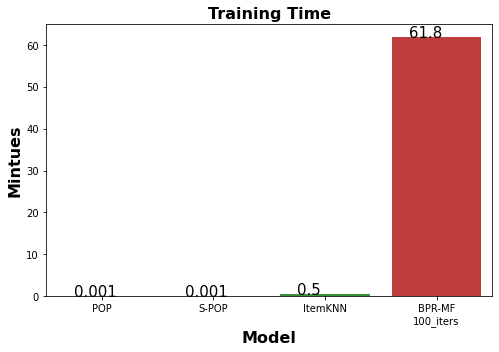

In [7]:
time_df =results[results.metric =='TIME'].reset_index(drop=True)
time_df['score'] = time_df['score'] /60
plt.figure(figsize=(8,5))
ax = sns.barplot(x='model', y='score',data =time_df)
for i,p in enumerate(ax.patches):
    value = '{:.3f}'.format(p.get_height())
    if i>1:
        value = '{:.1f}'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.25
    y = p.get_y() + p.get_height()
    ax.annotate(value, (x, y), size = 15)
plt.title("Training Time",fontsize = 16,weight = 'bold')
plt.xlabel('Model',fontsize = 16,weight = 'bold')
plt.ylabel('Mintues',fontsize = 16,weight = 'bold')
plt.show()

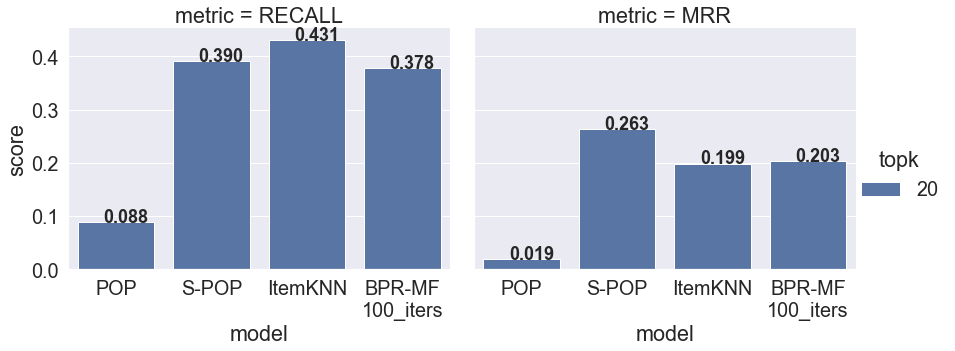

In [8]:
sns.set(font_scale = 1.8)
ax = sns.catplot(x='model', y='score',hue="topk",col="metric", data = results[results.topk !=0], kind="bar",height=5, aspect=1.2)
for i in range(2):
    axx = ax.facet_axis(0,i)
    for p in axx.patches:
        value = '{:.3f}'.format(p.get_height())
        x = p.get_x() + p.get_width() / 3
        y = p.get_y() + p.get_height()
        axx.annotate(value, (x, y), size = 18,weight = 'bold')
plt.show()
plt.style.use('default')


we try and reconstruct the results presented in paper,
lets present them and see if we're close:
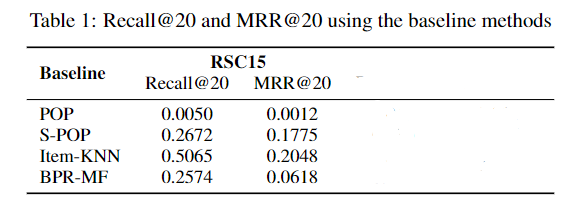

# <u>Recommendations with RNN</u>
In this work the authors argue that RNNs can be applied to session-based recommendation with remarkable results.<br>
They use BPR as a ranking loss and even introduce a new ranking loss function suited for a task of training these kind of models.

$$L_{BPR}\ \ =\ \ -\frac{1}{N_s} \cdot \sum_{j=1}^{N_s} log\ ({\large \sigma}\ (r_{s,i} - r_{s,j} )) $$

furthermore the authors introduced a devised version of BPR loss and it goes as follows:
$$L_{TOP1}\ \ =\ \ \frac{1}{N_s} \cdot \sum_{j=1}^{N_s} {\large \sigma}\ (r_{s,j} - r_{s,i} ) +{\large \sigma}( r_{s,j}^2)  $$
<br><br>
In the session-based recommendation, the first item which was clicked by the user, serves as an initial input for the RNN.<br>
Then, the deep learning model is queried based on this input to produce a recommendation. each further input(click) of user<br> will consecutivly produce an recommendation based on previous click.

We will focus on the original BPR loss. we will compare it to a baseline of MF-BPR also.
<u>The authors claim that they yielded the best results with an activation function of $Tanh$ and **adagrad** as an optimizer.</u><br><br><br>
**We are going to tackle this claim with trying different activations: LeakyRELU(0.2 negative slope) and Tanh with different optimizer: RMSprop,adagrad,Adam and see if we can conclude such a definitive claim**

# Important note!

#####  we've engaged a massive hyperparameters search while tuning the different GRU's. at each model we'll present, we will show only the top5 model but the following piece of code was fragmented and used parallely in different gpu's workstations:


In [ ]:
model_num_params = {}
count = 0
for model_name_x in ['BPR']:
  for final_act in ['leaky-0.2','tanh' , 'relu']:
    for optimizer in ['RMSProp','Adagrad','Adam']:
      for units in [50,100]:
        for batch_size in [32,50,64]:
          for dropout_input in [0,0.3,0.5,0.7]:
            for lr in [0.0001,0.001,0.01,0.05]:
              count+=1
              model_num_params[count]= [model_name_x,final_act,optimizer,units,batch_size,dropout_input,lr]
              print('#'*35,f'\nResults for:{model_num_params[count]}\n','#'*35)
              train_model(units = units,
                num_layers = 1,
                batch_size = batch_size,
                dropout_input = dropout_input,
                dropout_hidden = 0, #dropout between layers
                optimizer = optimizer,
                final_act = final_act,
                lr = lr,
                weight_decay = 0,
                momentum = 0,
                loss_type = model_name_x,
                model_name = f'BPR_{final_act}_{optimizer}_{units}_{batch_size}_{dropout_input}_{lr}',
                is_eval=False,
                load_model = None)
              print('#'*35,f'\nDONE!\n','#'*35)

To achieve this sort of many many GPU runs, we used simultaneously , local GPU, Colab PRO GPU, Kaggle GPU, by using fragmentations of the hyperparameters:
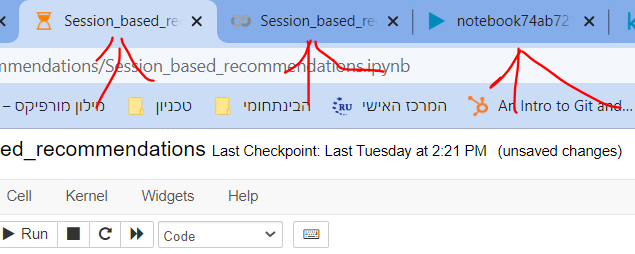

The following cell loads all the models which were under hyperparameters process:

In [9]:
results_gru = pd.DataFrame(columns = ['model', 'topk','metric','score','units','batch_size','dropout','lr'],dtype=object)
for name in ['model_BPR_leaky_rmsprop','model_BPR_leaky_adagrad','model_BPR_leaky_adam','model_BPR_tanh_adagrad',
            'model_BPR_tanh_rmsprop','model_BPR_tanh_adam']:
    for i in range(5):
        if name.split('_')[-1] == 'adam' and i==4:
            break
        mod = torch.load(f'checkpoint/{name}_{str(i+1)}_final.pt')
        mod_name = "_".join(['GRU']+name.split('_')[1::])+f'_{i+1}'
        #add Time
        timefit = sum(mod['model'].train_time)/60
        results_gru.loc[-1] = [mod_name,0,'TIME',timefit, mod['args'].hidden_size,mod['args'].batch_size,mod['args'].dropout_input,mod['args'].lr]
        results_gru.reset_index(drop = True,inplace = True) 
        #add Recall   
        results_gru.loc[-1] = [mod_name,20,'RECALL',mod['model'].recall,
                               mod['args'].hidden_size,
                               mod['args'].batch_size,
                               mod['args'].dropout_input,
                               mod['args'].lr] ; results_gru.reset_index(drop = True,inplace = True) 
        #add MRR   
        results_gru.loc[-1] = [mod_name,20,'MRR',mod['model'].mrr,
                               mod['args'].hidden_size,
                               mod['args'].batch_size,
                               mod['args'].dropout_input,
                               mod['args'].lr] ; results_gru.reset_index(drop = True,inplace = True) 
        #add LOSS  
        results_gru.loc[-1] = [mod_name,0,'LOSS',mod['model'].train_loss,
                               mod['args'].hidden_size,
                               mod['args'].batch_size,
                               mod['args'].dropout_input,
                               mod['args'].lr] ; results_gru.reset_index(drop = True,inplace = True) 
        #add VAL_LOSS  
        results_gru.loc[-1] = [mod_name,0,'VAL',mod['model'].val_loss,
                               mod['args'].hidden_size,
                               mod['args'].batch_size,
                               mod['args'].dropout_input,
                               mod['args'].lr] ; results_gru.reset_index(drop = True,inplace = True) 

The following cell creates a training function which loads python modules which we revised from the mentioned people at the beginning of the notebook:

In [ ]:
def train_model(units = 100,
                num_layers = 1,
                batch_size = 32,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adam',
                final_act = 'leaky-0.2',
                lr = 0.01,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'TOP1',
                model_name = 'GRU4REC-BPR',
                is_eval=False,
                load_model = None,
               n_epochs = 5,
               embedding_dim = -1):
                #type of loss function 'TOP1' / 'BPR' / 'CrossEntropy'
                #'RMSProp','Adagrad','Adam'
                #'tanh' , 'relu' , 'leaky-0.2'
    import datetime
    parser = argparse.ArgumentParser()

    parser.add_argument('--hidden_size', default=units, type=int) #Literature uses 100 / 1000 --> better is 100
    parser.add_argument('--num_layers', default=num_layers, type=int) #1 hidden layer
    parser.add_argument('--batch_size', default=batch_size, type=int) #50 in first paper and 32 in second paper
    parser.add_argument('--dropout_input', default=dropout_input, type=float) #0.5 for TOP and 0.3 for BPR
    parser.add_argument('--dropout_hidden', default=dropout_hidden, type=float) #0.5 for TOP and 0.3 for BPR
    parser.add_argument('--n_epochs', default=n_epochs, type=int) #number of epochs (10 in literature)
    parser.add_argument('--k_eval', default=20, type=int) #value of K durig Recall and MRR Evaluation
    # parse the optimizer arguments
    parser.add_argument('--optimizer_type', default=optimizer, type=str) #Optimizer --> Adagrad is the best according to literature
    parser.add_argument('--final_act', default=final_act, type=str) #Final Activation Function
    parser.add_argument('--lr', default=lr, type=float) #learning rate (Best according to literature 0.01 to 0.05)
    parser.add_argument('--weight_decay', default=weight_decay, type=float) #no weight decay
    parser.add_argument('--momentum', default=momentum, type=float) #no momentum
    parser.add_argument('--eps', default=1e-6, type=float) #not used
    parser.add_argument("-seed", type=int, default=22, help="Seed for random initialization") #Random seed setting
    parser.add_argument("-sigma", type=float, default=None, help="init weight -1: range [-sigma, sigma], -2: range [0, sigma]") # weight initialization [-sigma sigma] in literature
    parser.add_argument("--embedding_dim", type=int, default=embedding_dim, help="using embedding") 


    # parse the loss type
    parser.add_argument('--loss_type', default=loss_type, type=str) #type of loss function TOP1 / BPR / CrossEntropy
    # etc
    parser.add_argument('--time_sort', default=False, type=bool) #In case items are not sorted by time stamp
    parser.add_argument('--model_name', default=model_name, type=str)
    parser.add_argument('--save_dir', default='models/', type=str)
    parser.add_argument('--data_folder', default='data/', type=str)
    parser.add_argument('--train_data', default='train_samp_tr.txt', type=str)
    parser.add_argument('--valid_data', default='train_samp_valid.txt', type=str)
    parser.add_argument('--test_data', default='test_samp.txt', type=str)


    parser.add_argument('--load_model', default=None,  type=str)
    parser.add_argument('--checkpoint_dir', type=str, default='checkpoint/')

    parser.add_argument('-f') #Special parser to add only in ipython interface!

    # Get the arguments
    args = parser.parse_args()
    args.cuda = torch.cuda.is_available()
    #use random seed defined
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)


    if args.cuda:
        torch.cuda.manual_seed(args.seed)

    #Write Checkpoints with arguments used in a text file for reproducibility
    def make_checkpoint_dir():
        print("PARAMETER" + "-"*10)
        now = datetime.datetime.now()
        S = '{:02d}{:02d}{:02d}{:02d}'.format(now.month, now.day, now.hour, now.minute)
        save_dir = os.path.join(args.checkpoint_dir, S)
        if not os.path.exists(args.checkpoint_dir):
            os.mkdir(args.checkpoint_dir)

        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        args.checkpoint_dir = save_dir
        with open(os.path.join(args.checkpoint_dir, 'parameter.txt'), 'w') as f:
            for attr, value in sorted(args.__dict__.items()):
                print("{}={}".format(attr.upper(), value))
                f.write("{}={}\n".format(attr.upper(), value))
        print("---------" + "-"*10)

    #weight initialization if it was defined
    def init_model(model):
        if args.sigma is not None:
            for p in model.parameters():
                if args.sigma != -1 and args.sigma != -2:
                    sigma = args.sigma
                    p.data.uniform_(-sigma, sigma)
                elif len(list(p.size())) > 1:
                    sigma = np.sqrt(6.0 / (p.size(0) + p.size(1)))
                    if args.sigma == -1:
                        p.data.uniform_(-sigma, sigma)
                    else:
                        p.data.uniform_(0, sigma)


    print("Loading train data from {}".format(os.path.join(args.data_folder, args.train_data)))
    print("Loading valid data from {}".format(os.path.join(args.data_folder, args.valid_data)))
    print("Loading test data from {}".format(os.path.join(args.data_folder, args.test_data)))

    train_data = lib.Dataset(os.path.join(args.data_folder, args.train_data))
    valid_data = lib.Dataset(os.path.join(args.data_folder, args.valid_data), itemmap=train_data.itemmap)
    test_data = lib.Dataset(os.path.join(args.data_folder, args.test_data), itemmap=train_data.itemmap)


    make_checkpoint_dir()
        
    #set all the parameters according to the defined arguments
    input_size = len(train_data.items)
    hidden_size = args.hidden_size
    num_layers = args.num_layers
    output_size = input_size
    batch_size = args.batch_size
    dropout_input = args.dropout_input
    dropout_hidden = args.dropout_hidden
    embedding_dim = args.embedding_dim
    final_act = args.final_act
    loss_type = args.loss_type
    optimizer_type = args.optimizer_type
    lr = args.lr
    weight_decay = args.weight_decay
    momentum = args.momentum
    eps = args.eps
    n_epochs = args.n_epochs
    time_sort = args.time_sort
    #loss function
    loss_function = lib.LossFunction(loss_type=loss_type, use_cuda=args.cuda) #cuda is used with cross entropy only
    final_model =None
    if not is_eval: #training
        #Initialize the model
        model = lib.GRU4REC(input_size, hidden_size, output_size, final_act=final_act,
                            num_layers=num_layers, use_cuda=args.cuda, batch_size=batch_size,
                            dropout_input=dropout_input, dropout_hidden=dropout_hidden, embedding_dim=embedding_dim)
        #weights initialization
        init_model(model)
        #optimizer
        optimizer = lib.Optimizer(model.parameters(), optimizer_type=optimizer_type, lr=lr,
                                  weight_decay=weight_decay, momentum=momentum, eps=eps)
        #trainer class
        trainer = lib.Trainer(model, train_data=train_data, eval_data=valid_data, optim=optimizer,
                              use_cuda=args.cuda, loss_func=loss_function, batch_size=batch_size, args=args)
        print('#### START TRAINING....')
        trainer.train(0, n_epochs - 1)

    else: #testing
        if load_model is not None:
            print("Loading pre-trained model from {}".format(load_model))
            try:
                checkpoint = torch.load(load_model)
            except:
                checkpoint = torch.load(load_model, map_location=lambda storage, loc: storage)
            model = checkpoint["model"]
            model.gru.flatten_parameters()
            evaluation = lib.Evaluation(model, loss_function, use_cuda=args.cuda, k = args.k_eval)
            loss, recall, mrr = evaluation.eval(test_data, batch_size)
            checkpoint["model"].recall = recall
            checkpoint["model"].mrr = mrr
            # model_name = os.path.join(args.checkpoint_dir, f"model_{args.model_name}_final.pt")
            torch.save(checkpoint, f"checkpoint/model_{args.model_name}_final.pt")
            final_model =checkpoint["model"]
            print("Final result: recall = {:.2f}, mrr = {:.2f}".format(recall, mrr))
            print(f"Saved final model as model_{args.model_name}_final.pt")
        else:
            print("No Pretrained Model was found!")

    return final_model

## Firstly, lets recreate the best model presented in the paper:
**GRU network with tanh as final activation and using adagrad**

# GRU with BPR loss, Tanh activation and Adagrad optimizer:
we'll present the top 5 results in order the graphs to be more tidy and concise

In [ ]:
#model 1 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 50,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adagrad',
                final_act = 'tanh',
                lr = 0.05,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_tanh_adagrad_1',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'tanh', 'Adagrad', 50, 50, 0, 0.05]
##################
#model 2 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 64,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adagrad',
                final_act = 'tanh',
                lr = 0.05,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_tanh_adagrad_2',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ::['BPR', 'tanh', 'Adagrad', 50, 64, 0, 0.05]
##################
#model 3 
#train 10 epochs
train_model(units = 100,
                num_layers = 1,
                batch_size = 32,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adagrad',
                final_act = 'tanh',
                lr = 0.05,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_tanh_adagrad_3',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ::['BPR', 'tanh', 'Adagrad', 100, 32, 0, 0.05]
##################
#model 4 
#train 10 epochs
train_model(units = 100,
                num_layers = 1,
                batch_size = 50,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adagrad',
                final_act = 'tanh',
                lr = 0.05,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_tanh_adagrad_4',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'tanh', 'Adagrad', 100, 50, 0, 0.05]
##################
#model 5 
#train 10 epochs
train_model(units = 100,
                num_layers = 1,
                batch_size = 64,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adagrad',
                final_act = 'tanh',
                lr = 0.05,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_tanh_adagrad_5',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'tanh', 'Adagrad', 100, 64, 0, 0.05]


Evaluate the 5 models

In [ ]:
for i,batch in enumerate([50,64,32,50,64]):
    _ = train_model(batch_size = batch,is_eval=True,model_name=f'BPR_tanh_adagrad_{str(i+1)}', load_model= f'checkpoint/BPR_tanh_adagrad_{str(i+1)}.pt')


# plotting the results:

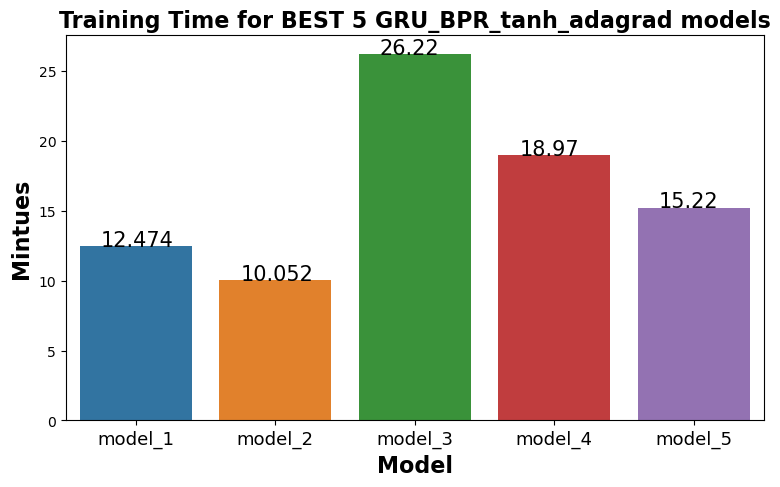

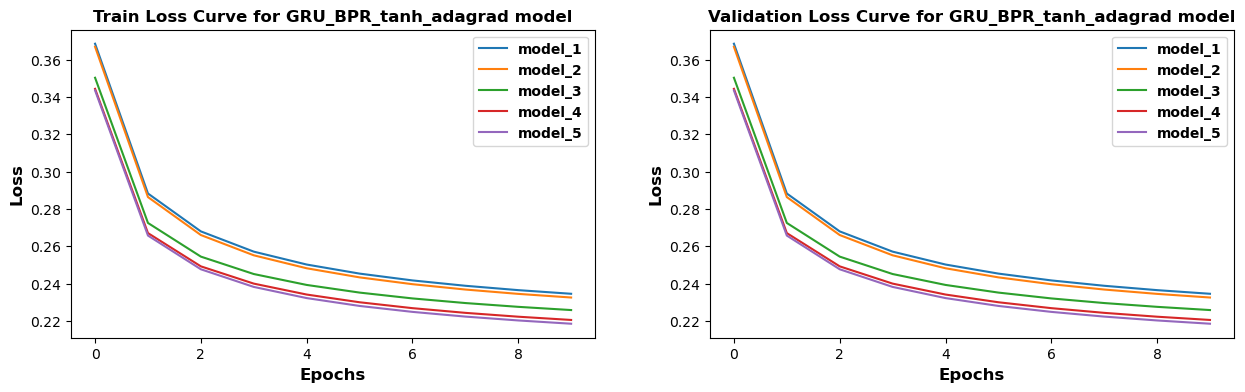

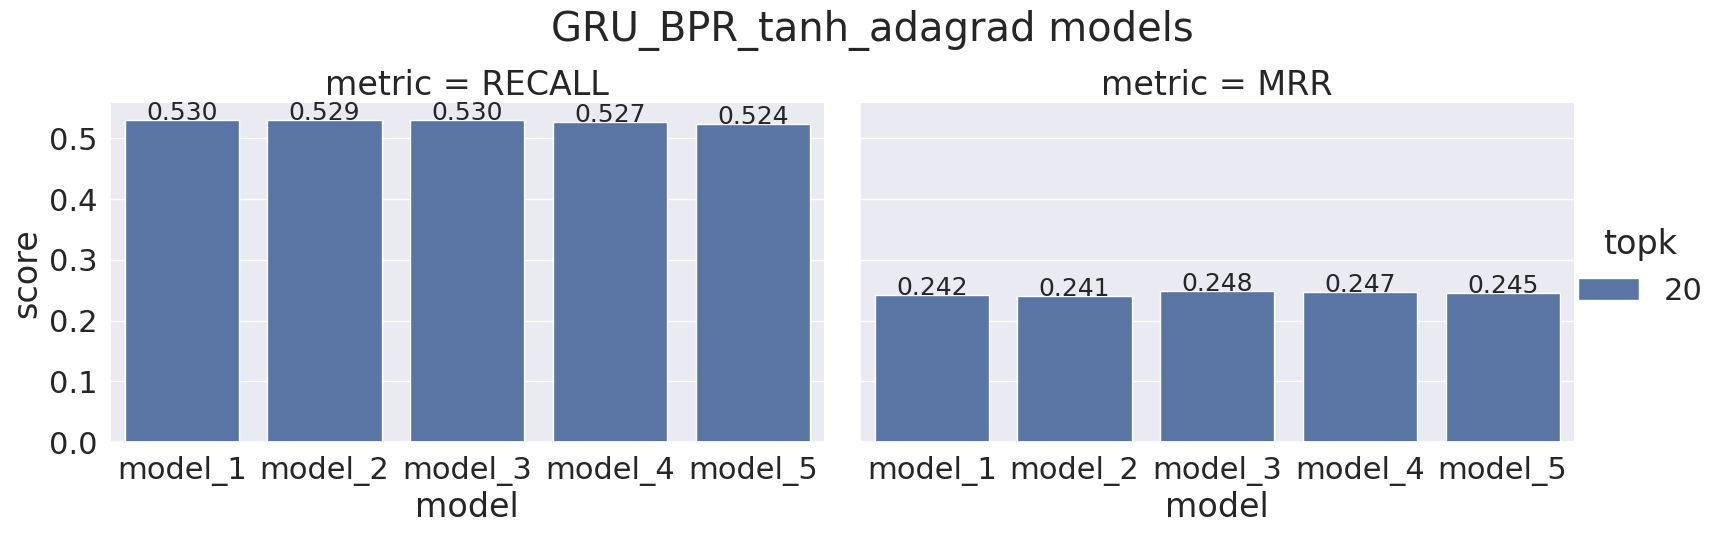

In [10]:
name_model = 'GRU_BPR_tanh_adagrad'
df = results_gru[results_gru.model.apply(lambda x: x[0:-2]) == name_model]
df.model = df.model.apply(lambda x: 'model_'+str(x[-1]))
#TIME EVALUATION
plt.figure(figsize=(9,5))
ax = sns.barplot(x='model', y='score',data =df[df.metric =='TIME'])
for i,p in enumerate(ax.patches):
    value = '{:.3f}'.format(p.get_height())
    if i>1:
        value = '{:.2f}'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.25
    y = p.get_y() + p.get_height()
    ax.annotate(value, (x, y), size = 15)
plt.xticks(ticks = np.arange(5),labels=[f'model_{i}' for i in range(1,6)],fontsize = 13)
plt.title(f"Training Time for BEST 5 {name_model} models",fontsize = 16,weight = 'bold')
plt.xlabel('Model',fontsize = 16,weight = 'bold')
plt.ylabel('Mintues',fontsize = 16,weight = 'bold')
plt.show()

#LOSS EVALUATION
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,4))
for nll,(name,scores) in df[df.metric=='LOSS'][['model','score']].iterrows():
    ax[0].plot(scores,label=name) 
ax[0].set_title(f"Train Loss Curve for {name_model } model",fontsize = 12,weight="bold")
ax[0].set_xlabel("Epochs",fontsize = 12,weight="bold")
ax[0].set_ylabel("Loss",fontsize = 12,weight="bold")
ax[0].legend(prop={'weight':'bold'})    
for nll,(name,scores) in df[df.metric=='LOSS'][['model','score']].iterrows():
    ax[1].plot(scores,label=name) 
ax[1].set_title(f"Validation Loss Curve for {name_model } model",fontsize = 12,weight="bold")
ax[1].set_xlabel("Epochs",fontsize = 12,weight="bold")
ax[1].set_ylabel("Loss",fontsize = 12,weight="bold")
ax[1].legend(prop={'weight':'bold'})  
fig.subplots_adjust(wspace= 0.22)

#METRICS EVALUATION
sns.set(font_scale = 2)
ax = sns.catplot(x='model', y='score',hue="topk",col="metric", data = df[df.topk !=0], kind="bar",height=5.2,aspect=1.52)
for i in range(2):
    axx = ax.facet_axis(0,i)
    for p in axx.patches:
        value = '{:.3f}'.format(p.get_height())
        x = p.get_x() + p.get_width() / 2 - 0.25
        y = p.get_y() + p.get_height()
        axx.annotate(value, (x, y), size = 18)
ax.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
ax.fig.suptitle(f'{name_model } models')
plt.style.use('default')
df = results_gru[results_gru.model.apply(lambda x: x[0:-2]) == name_model]

The model with best Recall and MRR is model 3

**As shown above, the model offered in paper will be represented by the following model:**

In [11]:
df[df.model == name_model+'_3']

,model,topk,metric,score,units,batch_size,dropout,lr
80,GRU_BPR_tanh_adagrad_3,0,TIME,26.224716,100,32,0,0.05
81,GRU_BPR_tanh_adagrad_3,20,RECALL,0.530401,100,32,0,0.05
82,GRU_BPR_tanh_adagrad_3,20,MRR,0.24832,100,32,0,0.05
83,GRU_BPR_tanh_adagrad_3,0,LOSS,"[0.3503511653723741, 0.2724868032425259, 0.254...",100,32,0,0.05
84,GRU_BPR_tanh_adagrad_3,0,VAL,"[0.3576662820194142, 0.33482902270188547, 0.32...",100,32,0,0.05


In [12]:
# ['BPR', 'tanh', 'Adagrad', 100, 32, 0, 0.05]
paper_model =torch.load('checkpoint/model_BPR_tanh_adagrad_3_final.pt')
print(paper_model['model'])
print(paper_model['args'])

GRU4REC(
  (h2o): Linear(in_features=100, out_features=18101, bias=True)
  (final_activation): Tanh()
  (gru): GRU(18101, 100)
)
Namespace(batch_size=32, checkpoint_dir='checkpoint/02101434', cuda=True, data_folder='data/', dropout_hidden=0, dropout_input=0, embedding_dim=-1, eps=1e-06, f='C:\\Users\\Gil zeevi\\AppData\\Roaming\\jupyter\\runtime\\kernel-03fd1012-5c0b-4919-8c55-a731fd28d6e1.json', final_act='tanh', hidden_size=100, k_eval=20, load_model=None, loss_type='BPR', lr=0.05, model_name='BPR_tanh_adagrad_3', momentum=0, n_epochs=10, num_layers=1, optimizer_type='Adagrad', save_dir='models/', seed=22, sigma=None, test_data='test_samp.txt', time_sort=False, train_data='train_samp_tr.txt', valid_data='train_samp_valid.txt', weight_decay=0)


# Now, lets try and find a competitive model to the one proposed in paper.<br>
we will try the following models:
 - GRU with BPR loss, LeakyRELU activation and RMSProp optimizer
 - GRU with BPR loss, LeakyRELU activation and Adagrad optimizer
 - GRU with BPR loss, LeakyRELU activation and Adam optimizer
 - GRU with BPR loss, Tanh activation and RMSProp optimizer
 - GRU with BPR loss, Tanh activation and Adam optimizer
 <br> <br>
**Our purpose is to tackle the statement in paper that GRU with BPR loss, Tanh activation and Adagrad optimizer yield the best results**

# GRU with BPR loss, LeakyRelu activation  and RMSprop optimizer:
we'll present the top 5 results in order the graphs to be more tidy and concise

In [ ]:
#model 1 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 50,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'RMSProp',
                final_act = 'leaky-0.2',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_leaky_rmsprop_1',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'leaky-0.2', 'RMSProp', 50, 50, 0, 0.001]
##################
#model 2 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 64,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'RMSProp',
                final_act = 'leaky-0.2',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_leaky_rmsprop_2',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'leaky-0.2', 'RMSProp', 50, 64, 0, 0.001]
##################
#model 3 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 32,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'RMSProp',
                final_act = 'leaky-0.2',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_leaky_rmsprop_3',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'leaky-0.2', 'RMSProp', 50, 32, 0, 0.001]
##################
#model 4 
#train 10 epochs
train_model(units = 100,
                num_layers = 1,
                batch_size = 64,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'RMSProp',
                final_act = 'leaky-0.2',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_leaky_rmsprop_4',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'leaky-0.2', 'RMSProp', 100, 64, 0, 0.001]
##################
#model 5 
#train 10 epochs
train_model(units = 100,
                num_layers = 1,
                batch_size = 50,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'RMSProp',
                final_act = 'leaky-0.2',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_leaky_rmsprop_5',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'leaky-0.2', 'RMSProp', 100, 50, 0, 0.001]


Evaluate the 5 models

In [ ]:
for i,batch in enumerate([50,64,32,64,50]):
    _ = train_model(batch_size = batch,is_eval=True,model_name=f'BPR_leaky_rmsprop_{str(i+1)}', load_model= f'checkpoint/BPR_leaky_rmsprop_{str(i+1)}.pt')


# plotting the results:

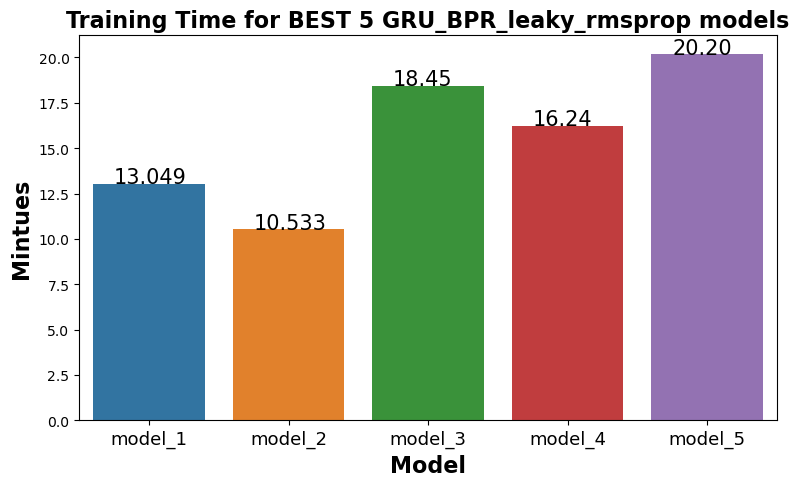

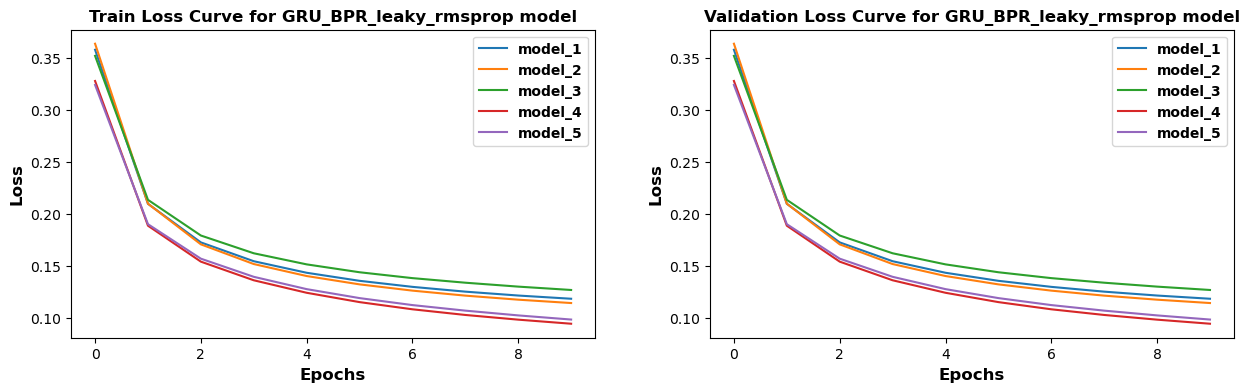

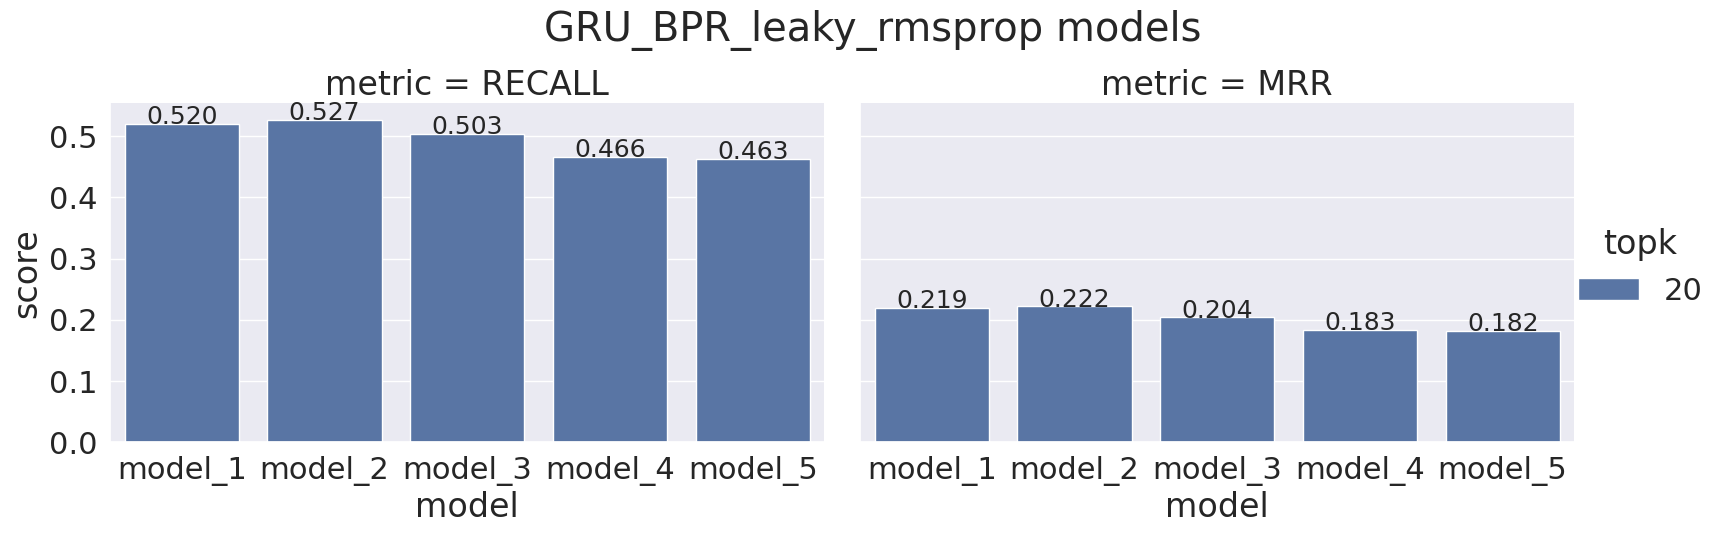

In [13]:
name_model = 'GRU_BPR_leaky_rmsprop'
df = results_gru[results_gru.model.apply(lambda x: x[0:-2]) == name_model]
df.model = df.model.apply(lambda x: 'model_'+str(x[-1]))
#TIME EVALUATION
plt.figure(figsize=(9,5))
ax = sns.barplot(x='model', y='score',data =df[df.metric =='TIME'])
for i,p in enumerate(ax.patches):
    value = '{:.3f}'.format(p.get_height())
    if i>1:
        value = '{:.2f}'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.25
    y = p.get_y() + p.get_height()
    ax.annotate(value, (x, y), size = 15)
plt.xticks(ticks = np.arange(5),labels=[f'model_{i}' for i in range(1,6)],fontsize = 13)
plt.title(f"Training Time for BEST 5 {name_model} models",fontsize = 16,weight = 'bold')
plt.xlabel('Model',fontsize = 16,weight = 'bold')
plt.ylabel('Mintues',fontsize = 16,weight = 'bold')
plt.show()

#LOSS EVALUATION
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,4))
for nll,(name,scores) in df[df.metric=='LOSS'][['model','score']].iterrows():
    ax[0].plot(scores,label=name) 
ax[0].set_title(f"Train Loss Curve for {name_model } model",fontsize = 12,weight="bold")
ax[0].set_xlabel("Epochs",fontsize = 12,weight="bold")
ax[0].set_ylabel("Loss",fontsize = 12,weight="bold")
ax[0].legend(prop={'weight':'bold'})    
for nll,(name,scores) in df[df.metric=='LOSS'][['model','score']].iterrows():
    ax[1].plot(scores,label=name) 
ax[1].set_title(f"Validation Loss Curve for {name_model } model",fontsize = 12,weight="bold")
ax[1].set_xlabel("Epochs",fontsize = 12,weight="bold")
ax[1].set_ylabel("Loss",fontsize = 12,weight="bold")
ax[1].legend(prop={'weight':'bold'})  
fig.subplots_adjust(wspace= 0.22)

#METRICS EVALUATION
sns.set(font_scale = 2)
ax = sns.catplot(x='model', y='score',hue="topk",col="metric", data = df[df.topk !=0], kind="bar",height=5.2,aspect=1.52)
for i in range(2):
    axx = ax.facet_axis(0,i)
    for p in axx.patches:
        value = '{:.3f}'.format(p.get_height())
        x = p.get_x() + p.get_width() / 2 - 0.25
        y = p.get_y() + p.get_height()
        axx.annotate(value, (x, y), size = 18)
ax.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
ax.fig.suptitle(f'{name_model } models')
plt.style.use('default')
df = results_gru[results_gru.model.apply(lambda x: x[0:-2]) == name_model]

The model with best Recall and MRR is model 2

In [14]:
df[df.model == name_model+'_2']

,model,topk,metric,score,units,batch_size,dropout,lr
5,GRU_BPR_leaky_rmsprop_2,0,TIME,10.533369,50,64,0,0.001
6,GRU_BPR_leaky_rmsprop_2,20,RECALL,0.526858,50,64,0,0.001
7,GRU_BPR_leaky_rmsprop_2,20,MRR,0.221716,50,64,0,0.001
8,GRU_BPR_leaky_rmsprop_2,0,LOSS,"[0.36397859520075565, 0.21018662468573918, 0.1...",50,64,0,0.001
9,GRU_BPR_leaky_rmsprop_2,0,VAL,"[0.40237834920342164, 0.28989179230173917, 0.2...",50,64,0,0.001


In [15]:
leaky_rms =torch.load('checkpoint/model_BPR_leaky_rmsprop_2_final.pt')
print(leaky_rms['model'])
print(leaky_rms['args'])

GRU4REC(
  (h2o): Linear(in_features=50, out_features=18101, bias=True)
  (final_activation): LeakyReLU(negative_slope=0.2)
  (gru): GRU(18101, 50)
)
Namespace(batch_size=64, checkpoint_dir='checkpoint/02101006', cuda=True, data_folder='data/', dropout_hidden=0, dropout_input=0, embedding_dim=-1, eps=1e-06, f='C:\\Users\\Gil zeevi\\AppData\\Roaming\\jupyter\\runtime\\kernel-03fd1012-5c0b-4919-8c55-a731fd28d6e1.json', final_act='leaky-0.2', hidden_size=50, k_eval=20, load_model=None, loss_type='BPR', lr=0.001, model_name='BPR_leaky_rmsprop_2', momentum=0, n_epochs=10, num_layers=1, optimizer_type='RMSProp', save_dir='models/', seed=22, sigma=None, test_data='test_samp.txt', time_sort=False, train_data='train_samp_tr.txt', valid_data='train_samp_valid.txt', weight_decay=0)


# GRU with BPR loss, LeakyRelu activation and Adagrad optimizer:
we'll present the top 5 results in order the graphs to be more tidy and concise

In [ ]:
#model 1 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 50,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adagrad',
                final_act = 'leaky-0.2',
                lr = 0.05,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_leaky_adagrad_1',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'leaky-0.2', 'Adagrad', 50, 50, 0, 0.05]
##################
#model 2 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 64,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adagrad',
                final_act = 'leaky-0.2',
                lr = 0.05,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_leaky_adagrad_2',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'leaky-0.2', 'Adagrad', 50, 64, 0, 0.05]
##################
#model 3 
#train 10 epochs
train_model(units = 100,
                num_layers = 1,
                batch_size = 50,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adagrad',
                final_act = 'leaky-0.2',
                lr = 0.05,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_leaky_adagrad_3',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# :['BPR', 'leaky-0.2', 'Adagrad', 100, 50, 0, 0.05]
##################
#model 4 
#train 10 epochs
train_model(units = 100,
                num_layers = 1,
                batch_size = 64,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adagrad',
                final_act = 'leaky-0.2',
                lr = 0.05,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_leaky_adagrad_4',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'leaky-0.2', 'Adagrad', 100, 64, 0, 0.05]
##################
#model 5 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 32,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adagrad',
                final_act = 'leaky-0.2',
                lr = 0.05,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_leaky_adagrad_5',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# :['BPR', 'leaky-0.2', 'Adagrad', 50, 32, 0, 0.05]


Evaluate the 5 models

In [ ]:
for i,batch in enumerate([50,64,50,64,32]):
    _ = train_model(batch_size = batch,is_eval=True,model_name=f'BPR_leaky_adagrad_{str(i+1)}', load_model= f'checkpoint/BPR_leaky_adagrad_{str(i+1)}.pt')
# ['BPR', 'leaky-0.2', 'Adagrad', 50, 50, 0, 0.05]
# ['BPR', 'leaky-0.2', 'Adagrad', 50, 64, 0, 0.05]
# :['BPR', 'leaky-0.2', 'Adagrad', 100, 50, 0, 0.05]
# ['BPR', 'leaky-0.2', 'Adagrad', 100, 64, 0, 0.05]
# :['BPR', 'leaky-0.2', 'Adagrad', 50, 32, 0, 0.05]


# plotting the results:

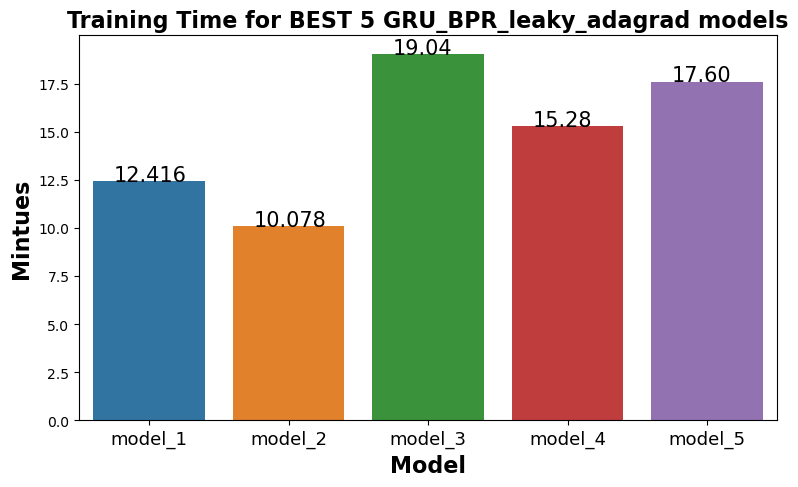

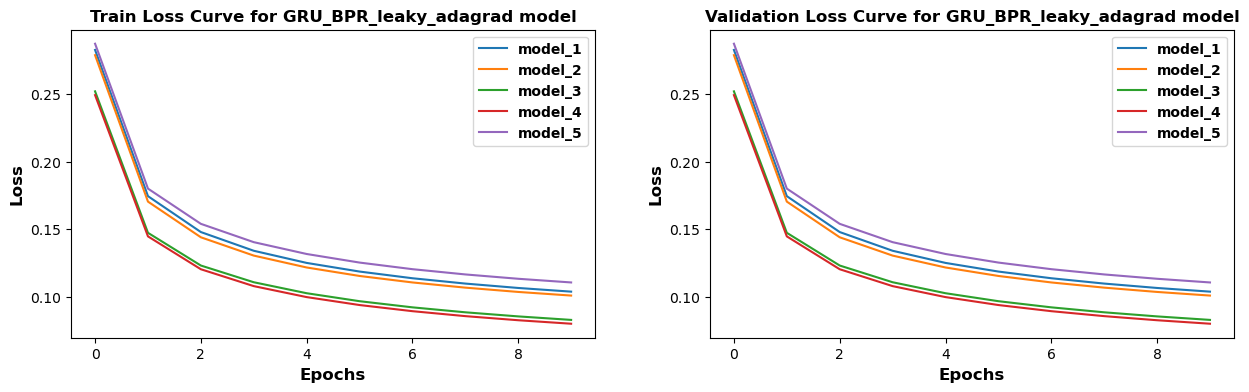

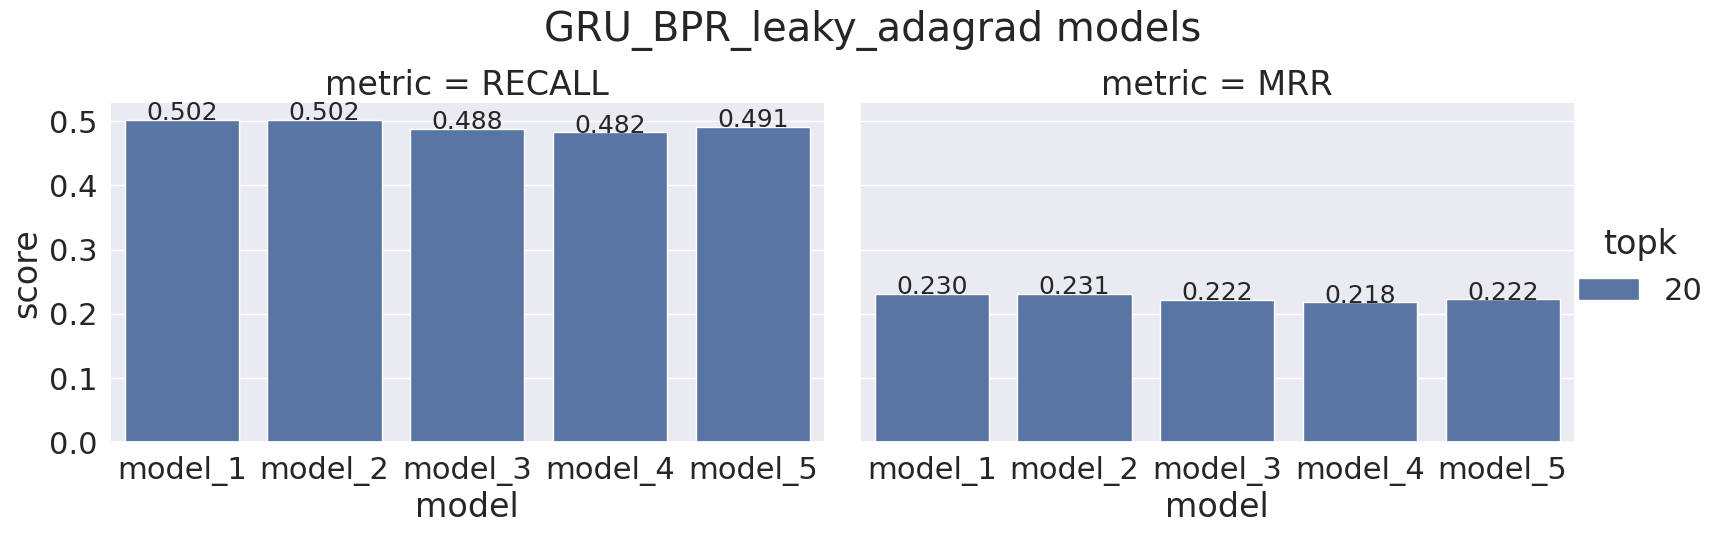

In [16]:
name_model = 'GRU_BPR_leaky_adagrad'
df = results_gru[results_gru.model.apply(lambda x: x[0:-2]) == name_model]
df.model = df.model.apply(lambda x: 'model_'+str(x[-1]))
#TIME EVALUATION
plt.figure(figsize=(9,5))
ax = sns.barplot(x='model', y='score',data =df[df.metric =='TIME'])
for i,p in enumerate(ax.patches):
    value = '{:.3f}'.format(p.get_height())
    if i>1:
        value = '{:.2f}'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.25
    y = p.get_y() + p.get_height()
    ax.annotate(value, (x, y), size = 15)
plt.xticks(ticks = np.arange(5),labels=[f'model_{i}' for i in range(1,6)],fontsize = 13)
plt.title(f"Training Time for BEST 5 {name_model} models",fontsize = 16,weight = 'bold')
plt.xlabel('Model',fontsize = 16,weight = 'bold')
plt.ylabel('Mintues',fontsize = 16,weight = 'bold')
plt.show()

#LOSS EVALUATION
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,4))
for nll,(name,scores) in df[df.metric=='LOSS'][['model','score']].iterrows():
    ax[0].plot(scores,label=name) 
ax[0].set_title(f"Train Loss Curve for {name_model } model",fontsize = 12,weight="bold")
ax[0].set_xlabel("Epochs",fontsize = 12,weight="bold")
ax[0].set_ylabel("Loss",fontsize = 12,weight="bold")
ax[0].legend(prop={'weight':'bold'})    
for nll,(name,scores) in df[df.metric=='LOSS'][['model','score']].iterrows():
    ax[1].plot(scores,label=name) 
ax[1].set_title(f"Validation Loss Curve for {name_model } model",fontsize = 12,weight="bold")
ax[1].set_xlabel("Epochs",fontsize = 12,weight="bold")
ax[1].set_ylabel("Loss",fontsize = 12,weight="bold")
ax[1].legend(prop={'weight':'bold'})  
fig.subplots_adjust(wspace= 0.22)

#METRICS EVALUATION
sns.set(font_scale = 2)
ax = sns.catplot(x='model', y='score',hue="topk",col="metric", data = df[df.topk !=0], kind="bar",height=5.2,aspect=1.52)
for i in range(2):
    axx = ax.facet_axis(0,i)
    for p in axx.patches:
        value = '{:.3f}'.format(p.get_height())
        x = p.get_x() + p.get_width() / 2 - 0.25
        y = p.get_y() + p.get_height()
        axx.annotate(value, (x, y), size = 18)
ax.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
ax.fig.suptitle(f'{name_model } models')
plt.style.use('default')
df = results_gru[results_gru.model.apply(lambda x: x[0:-2]) == name_model]

The model with best Recall and MRR is model 2

In [17]:
df[df.model == name_model+'_2']

,model,topk,metric,score,units,batch_size,dropout,lr
30,GRU_BPR_leaky_adagrad_2,0,TIME,10.078097,50,64,0,0.05
31,GRU_BPR_leaky_adagrad_2,20,RECALL,0.502002,50,64,0,0.05
32,GRU_BPR_leaky_adagrad_2,20,MRR,0.23143,50,64,0,0.05
33,GRU_BPR_leaky_adagrad_2,0,LOSS,"[0.27869221090700974, 0.17045288601136305, 0.1...",50,64,0,0.05
34,GRU_BPR_leaky_adagrad_2,0,VAL,"[0.3183553525483913, 0.26567622410906305, 0.23...",50,64,0,0.05


In [18]:
leaky_adagrad =torch.load('checkpoint/model_BPR_leaky_adagrad_2_final.pt')
print(leaky_adagrad['model'])
print(leaky_adagrad['args'])

GRU4REC(
  (h2o): Linear(in_features=50, out_features=18101, bias=True)
  (final_activation): LeakyReLU(negative_slope=0.2)
  (gru): GRU(18101, 50)
)
Namespace(batch_size=64, checkpoint_dir='checkpoint/02101124', cuda=True, data_folder='data/', dropout_hidden=0, dropout_input=0, embedding_dim=-1, eps=1e-06, f='C:\\Users\\Gil zeevi\\AppData\\Roaming\\jupyter\\runtime\\kernel-03fd1012-5c0b-4919-8c55-a731fd28d6e1.json', final_act='leaky-0.2', hidden_size=50, k_eval=20, load_model=None, loss_type='BPR', lr=0.05, model_name='BPR_leaky_adagrad_2', momentum=0, n_epochs=10, num_layers=1, optimizer_type='Adagrad', save_dir='models/', seed=22, sigma=None, test_data='test_samp.txt', time_sort=False, train_data='train_samp_tr.txt', valid_data='train_samp_valid.txt', weight_decay=0)


# GRU with BPR loss, LeakyRelu activation and Adam optimizer:
we'll present the top 5 results in order the graphs to be more tidy and concise

In [ ]:
# ['BPR', 'leaky-0.2', 'Adam', 50, 32, 0, 0.001]48
# ['BPR', 'leaky-0.2', 'Adam', 50, 50, 0, 0.001] 49
# ['BPR', 'leaky-0.2', 'Adam', 50, 64, 0, 0.001] 48
# ['BPR', 'leaky-0.2', 'Adam', 100, 50, 0, 0.001] 46
# ['BPR', 'leaky-0.2', 'Adam', 100, 64, 0, 0.001] 46

#model 1 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 32,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adam',
                final_act = 'leaky-0.2',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_leaky_adam_1',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
['BPR', 'leaky-0.2', 'Adam', 50, 32, 0, 0.001]
#################
#model 2 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 50,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adam',
                final_act = 'leaky-0.2',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_leaky_adam_2',
                is_eval=False,
                load_model = None,
                n_epochs = 7) 
# ['BPR', 'leaky-0.2', 'Adam', 50, 50, 0, 0.001]
##################
#model 3 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 64,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adam',
                final_act = 'leaky-0.2',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_leaky_adam_3',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# :['BPR', 'leaky-0.2', 'Adam', 50, 64, 0, 0.001]
# ##################
# #model 4 
# #train 10 epochs
train_model(units = 100,
                num_layers = 1,
                batch_size = 50,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adam',
                final_act = 'leaky-0.2',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_leaky_adam_4',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'leaky-0.2', 'Adam', 100, 50, 0, 0.001]
# ##################
# #model 5 
#train 10 epochs
train_model(units = 100,
                num_layers = 1,
                batch_size = 64,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adam',
                final_act = 'leaky-0.2',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_leaky_adam_5',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# :['BPR', 'leaky-0.2', 'Adam', 100, 64, 0, 0.001]


Evaluate the 5 models

In [ ]:
for i,batch in enumerate([32,50,64,50,64]):
    _ = train_model(batch_size = batch,is_eval=True,model_name=f'BPR_leaky_adam_{str(i+1)}', load_model= f'checkpoint/BPR_leaky_adam_{str(i+1)}.pt')
# ['BPR', 'leaky-0.2', 'Adam', 50, 32, 0, 0.001]48
# ['BPR', 'leaky-0.2', 'Adam', 50, 50, 0, 0.001] 49
# ['BPR', 'leaky-0.2', 'Adam', 50, 64, 0, 0.001] 48
# ['BPR', 'leaky-0.2', 'Adam', 100, 50, 0, 0.001] 46
# ['BPR', 'leaky-0.2', 'Adam', 100, 64, 0, 0.001] 46


# plotting the results:

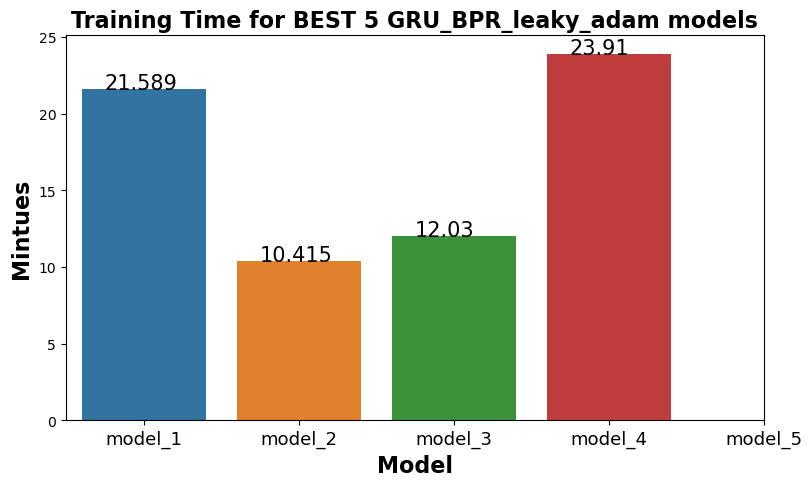

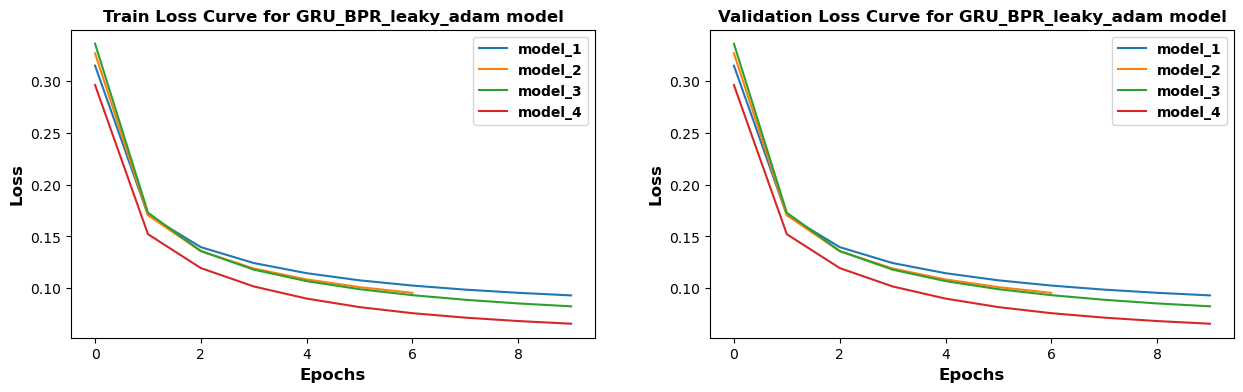

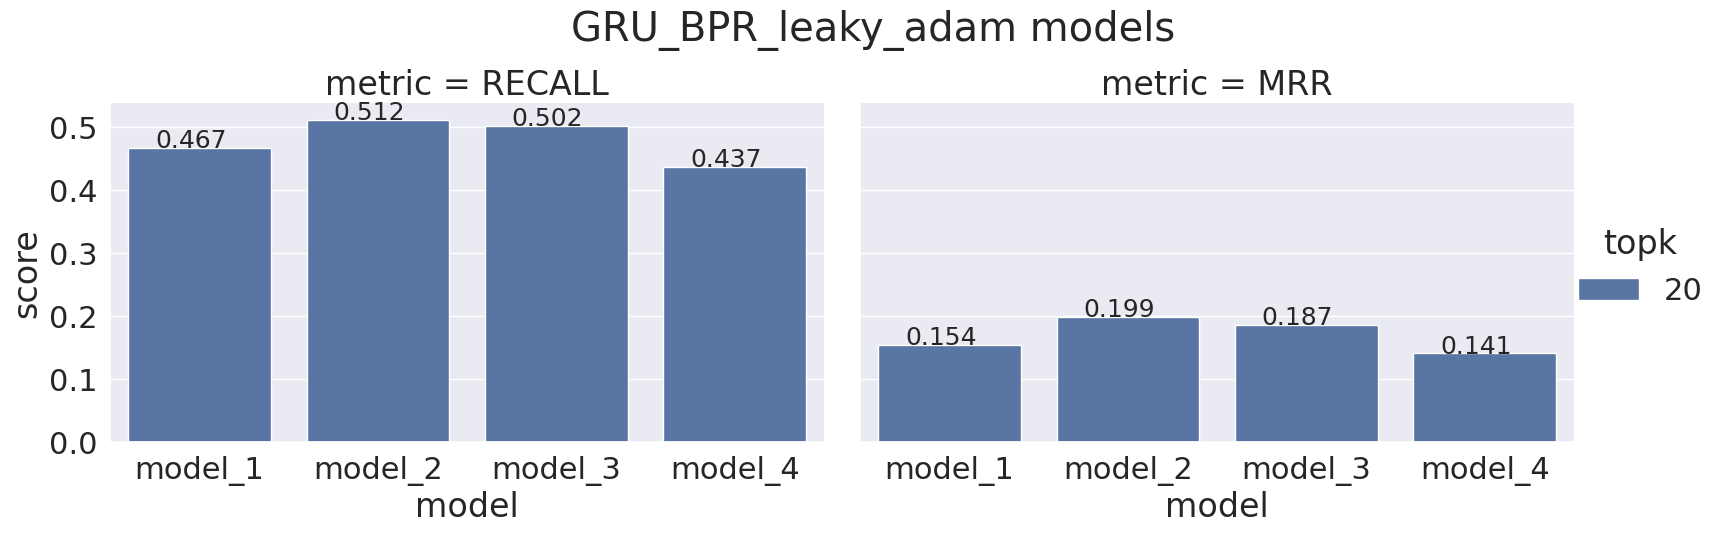

In [19]:
name_model = 'GRU_BPR_leaky_adam'
df = results_gru[results_gru.model.apply(lambda x: x[0:-2]) == name_model]
df.model = df.model.apply(lambda x: 'model_'+str(x[-1]))
#TIME EVALUATION
plt.figure(figsize=(9,5))
ax = sns.barplot(x='model', y='score',data =df[df.metric =='TIME'])
for i,p in enumerate(ax.patches):
    value = '{:.3f}'.format(p.get_height())
    if i>1:
        value = '{:.2f}'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.25
    y = p.get_y() + p.get_height()
    ax.annotate(value, (x, y), size = 15)
plt.xticks(ticks = np.arange(5),labels=[f'model_{i}' for i in range(1,6)],fontsize = 13)
plt.title(f"Training Time for BEST 5 {name_model} models",fontsize = 16,weight = 'bold')
plt.xlabel('Model',fontsize = 16,weight = 'bold')
plt.ylabel('Mintues',fontsize = 16,weight = 'bold')
plt.show()

#LOSS EVALUATION
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,4))
for nll,(name,scores) in df[df.metric=='LOSS'][['model','score']].iterrows():
    ax[0].plot(scores,label=name) 
ax[0].set_title(f"Train Loss Curve for {name_model } model",fontsize = 12,weight="bold")
ax[0].set_xlabel("Epochs",fontsize = 12,weight="bold")
ax[0].set_ylabel("Loss",fontsize = 12,weight="bold")
ax[0].legend(prop={'weight':'bold'})    
for nll,(name,scores) in df[df.metric=='LOSS'][['model','score']].iterrows():
    ax[1].plot(scores,label=name) 
ax[1].set_title(f"Validation Loss Curve for {name_model } model",fontsize = 12,weight="bold")
ax[1].set_xlabel("Epochs",fontsize = 12,weight="bold")
ax[1].set_ylabel("Loss",fontsize = 12,weight="bold")
ax[1].legend(prop={'weight':'bold'})  
fig.subplots_adjust(wspace= 0.22)

#METRICS EVALUATION
sns.set(font_scale = 2)
ax = sns.catplot(x='model', y='score',hue="topk",col="metric", data = df[df.topk !=0], kind="bar",height=5.2,aspect=1.52)
for i in range(2):
    axx = ax.facet_axis(0,i)
    for p in axx.patches:
        value = '{:.3f}'.format(p.get_height())
        x = p.get_x() + p.get_width() / 2 - 0.25
        y = p.get_y() + p.get_height()
        axx.annotate(value, (x, y), size = 18)
ax.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
ax.fig.suptitle(f'{name_model } models')
plt.style.use('default')
df = results_gru[results_gru.model.apply(lambda x: x[0:-2]) == name_model]

The model with best Recall and MRR is model 2

In [20]:
df[df.model == name_model+'_2']

,model,topk,metric,score,units,batch_size,dropout,lr
55,GRU_BPR_leaky_adam_2,0,TIME,10.415381,50,50,0,0.001
56,GRU_BPR_leaky_adam_2,20,RECALL,0.512006,50,50,0,0.001
57,GRU_BPR_leaky_adam_2,20,MRR,0.199326,50,50,0,0.001
58,GRU_BPR_leaky_adam_2,0,LOSS,"[0.32677986381381013, 0.1704773831039516, 0.13...",50,50,0,0.001
59,GRU_BPR_leaky_adam_2,0,VAL,"[0.3013208153861973, 0.2212482655076803, 0.195...",50,50,0,0.001


In [21]:
leaky_adam =torch.load('checkpoint/model_BPR_leaky_adam_2_final.pt')
print(leaky_adam['model'])
print(leaky_adam['args'])

GRU4REC(
  (h2o): Linear(in_features=50, out_features=18101, bias=True)
  (final_activation): LeakyReLU(negative_slope=0.2)
  (gru): GRU(18101, 50)
)
Namespace(batch_size=50, checkpoint_dir='checkpoint/02101844', cuda=True, data_folder='data/', dropout_hidden=0, dropout_input=0, embedding_dim=-1, eps=1e-06, f='C:\\Users\\Gil zeevi\\AppData\\Roaming\\jupyter\\runtime\\kernel-03fd1012-5c0b-4919-8c55-a731fd28d6e1.json', final_act='leaky-0.2', hidden_size=50, k_eval=20, load_model=None, loss_type='BPR', lr=0.001, model_name='BPR_leaky_adam_2', momentum=0, n_epochs=7, num_layers=1, optimizer_type='Adam', save_dir='models/', seed=22, sigma=None, test_data='test_samp.txt', time_sort=False, train_data='train_samp_tr.txt', valid_data='train_samp_valid.txt', weight_decay=0)


# GRU with BPR loss, Tanh activation and RMSprop optimizer:
we'll present the top 5 results in order the graphs to be more tidy and concise

In [ ]:
#model 1 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 50,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'RMSProp',
                final_act = 'tanh',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_tanh_rmsprop_1',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# :['BPR', 'tanh', 'RMSProp', 50, 50, 0, 0.001]
##################
#model 2 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 64,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'RMSProp',
                final_act = 'tanh',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_tanh_rmsprop_2',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'tanh', 'RMSProp', 50, 64, 0, 0.001]
##################
#model 3 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 32,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'RMSProp',
                final_act = 'tanh',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_tanh_rmsprop_3',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ::['BPR', 'tanh', 'RMSProp', 50, 32, 0, 0.001]
##################
#model 4 
#train 10 epochs
train_model(units = 100,
                num_layers = 1,
                batch_size = 64,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'RMSProp',
                final_act = 'tanh',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_tanh_rmsprop_4',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# :['BPR', 'tanh', 'RMSProp', 100, 64, 0, 0.001]
##################
#model 5 
#train 10 epochs
train_model(units = 100,
                num_layers = 1,
                batch_size = 50,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'RMSProp',
                final_act = 'tanh',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_tanh_rmsprop_5',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'tanh', 'RMSProp', 100, 50, 0, 0.001]


Evaluate the 5 models

In [ ]:
for i,batch in enumerate([50,64,32,64,50]):
    _ = train_model(batch_size = batch,is_eval=True,model_name=f'BPR_tanh_rmsprop_{str(i+1)}', load_model= f'checkpoint/BPR_tanh_rmsprop_{str(i+1)}.pt')
# :['BPR', 'tanh', 'RMSProp', 50, 50, 0, 0.001]
# ['BPR', 'tanh', 'RMSProp', 50, 64, 0, 0.001]
# ::['BPR', 'tanh', 'RMSProp', 50, 32, 0, 0.001]
# :['BPR', 'tanh', 'RMSProp', 100, 64, 0, 0.001]
# ['BPR', 'tanh', 'RMSProp', 100, 50, 0, 0.001]


# plotting the results:

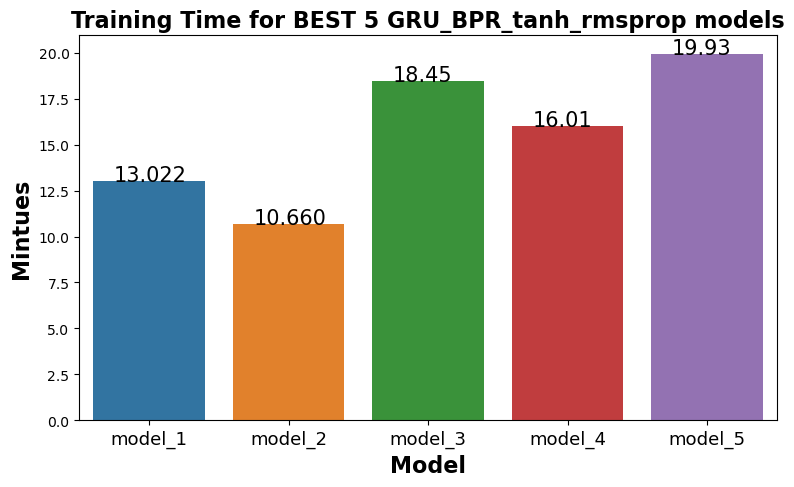

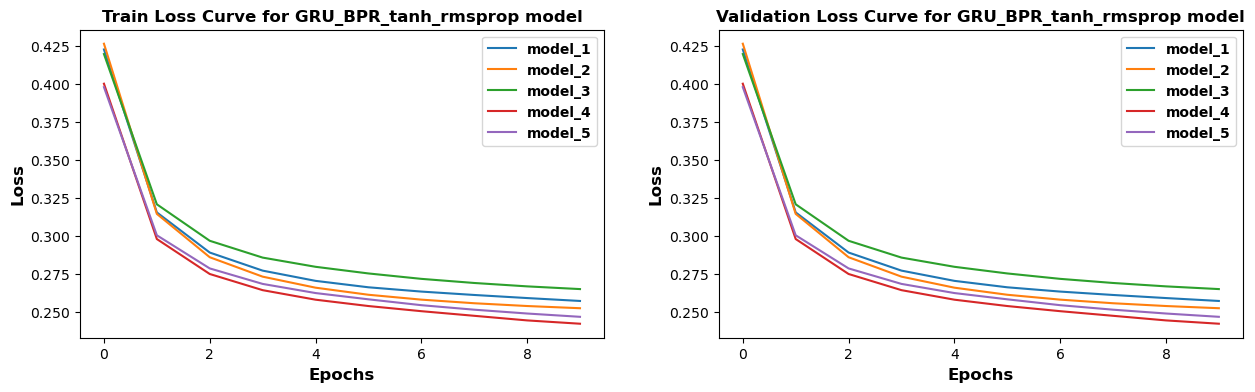

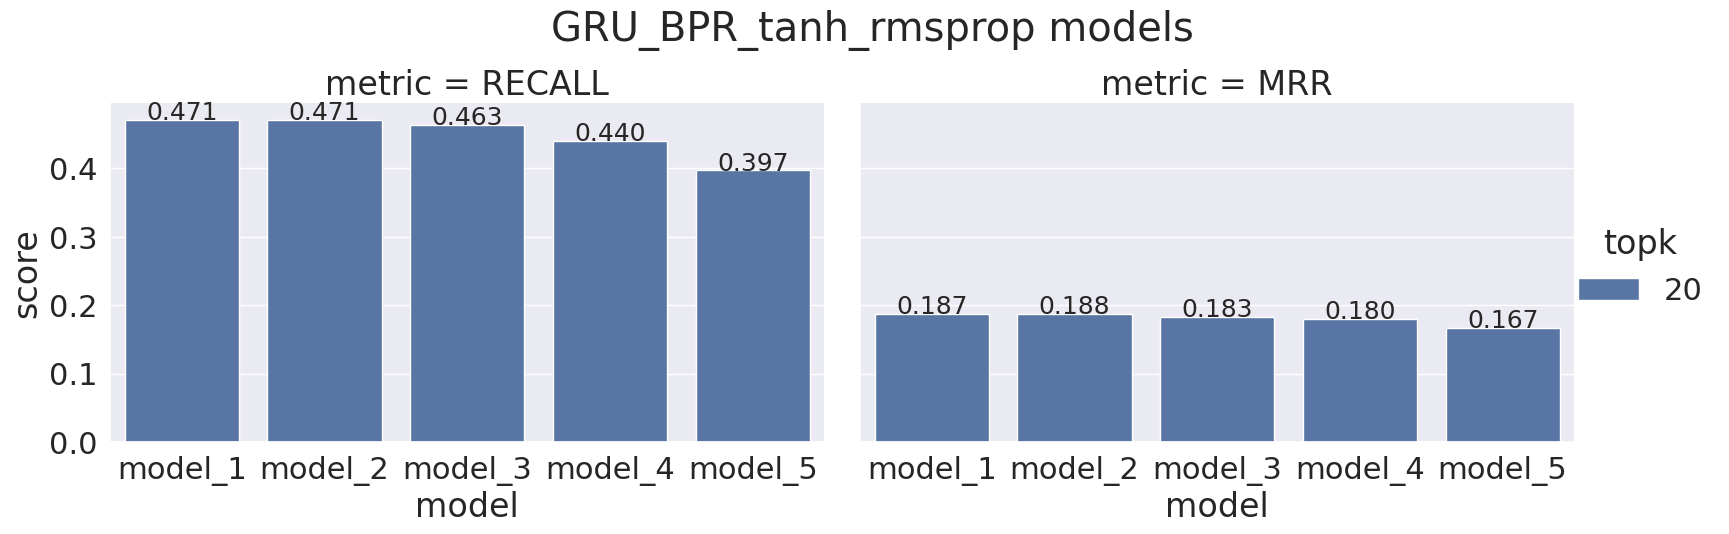

In [22]:
name_model = 'GRU_BPR_tanh_rmsprop'
df = results_gru[results_gru.model.apply(lambda x: x[0:-2]) == name_model]
df.model = df.model.apply(lambda x: 'model_'+str(x[-1]))
#TIME EVALUATION
plt.figure(figsize=(9,5))
ax = sns.barplot(x='model', y='score',data =df[df.metric =='TIME'])
for i,p in enumerate(ax.patches):
    value = '{:.3f}'.format(p.get_height())
    if i>1:
        value = '{:.2f}'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.25
    y = p.get_y() + p.get_height()
    ax.annotate(value, (x, y), size = 15)
plt.xticks(ticks = np.arange(5),labels=[f'model_{i}' for i in range(1,6)],fontsize = 13)
plt.title(f"Training Time for BEST 5 {name_model} models",fontsize = 16,weight = 'bold')
plt.xlabel('Model',fontsize = 16,weight = 'bold')
plt.ylabel('Mintues',fontsize = 16,weight = 'bold')
plt.show()

#LOSS EVALUATION
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,4))
for nll,(name,scores) in df[df.metric=='LOSS'][['model','score']].iterrows():
    ax[0].plot(scores,label=name) 
ax[0].set_title(f"Train Loss Curve for {name_model } model",fontsize = 12,weight="bold")
ax[0].set_xlabel("Epochs",fontsize = 12,weight="bold")
ax[0].set_ylabel("Loss",fontsize = 12,weight="bold")
ax[0].legend(prop={'weight':'bold'})    
for nll,(name,scores) in df[df.metric=='LOSS'][['model','score']].iterrows():
    ax[1].plot(scores,label=name) 
ax[1].set_title(f"Validation Loss Curve for {name_model } model",fontsize = 12,weight="bold")
ax[1].set_xlabel("Epochs",fontsize = 12,weight="bold")
ax[1].set_ylabel("Loss",fontsize = 12,weight="bold")
ax[1].legend(prop={'weight':'bold'})  
fig.subplots_adjust(wspace= 0.22)

#METRICS EVALUATION
sns.set(font_scale = 2)
ax = sns.catplot(x='model', y='score',hue="topk",col="metric", data = df[df.topk !=0], kind="bar",height=5.2,aspect=1.52)
for i in range(2):
    axx = ax.facet_axis(0,i)
    for p in axx.patches:
        value = '{:.3f}'.format(p.get_height())
        x = p.get_x() + p.get_width() / 2 - 0.25
        y = p.get_y() + p.get_height()
        axx.annotate(value, (x, y), size = 18)
ax.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
ax.fig.suptitle(f'{name_model } models')
plt.style.use('default')
df = results_gru[results_gru.model.apply(lambda x: x[0:-2]) == name_model]

The model with best Recall and MRR is model 2

In [23]:
df[df.model == name_model+'_2']

,model,topk,metric,score,units,batch_size,dropout,lr
100,GRU_BPR_tanh_rmsprop_2,0,TIME,10.659857,50,64,0,0.001
101,GRU_BPR_tanh_rmsprop_2,20,RECALL,0.471021,50,64,0,0.001
102,GRU_BPR_tanh_rmsprop_2,20,MRR,0.18756,50,64,0,0.001
103,GRU_BPR_tanh_rmsprop_2,0,LOSS,"[0.42655457047692735, 0.3146867639078318, 0.28...",50,64,0,0.001
104,GRU_BPR_tanh_rmsprop_2,0,VAL,"[0.4265182602723793, 0.3658284210124456, 0.347...",50,64,0,0.001


In [24]:
tanh_rms =torch.load('checkpoint/model_BPR_tanh_rmsprop_2_final.pt')
print(tanh_rms['model'])
print(tanh_rms['args'])

GRU4REC(
  (h2o): Linear(in_features=50, out_features=18101, bias=True)
  (final_activation): Tanh()
  (gru): GRU(18101, 50)
)
Namespace(batch_size=64, checkpoint_dir='checkpoint/02102251', cuda=True, data_folder='data/', dropout_hidden=0, dropout_input=0, embedding_dim=-1, eps=1e-06, f='C:\\Users\\Gil zeevi\\AppData\\Roaming\\jupyter\\runtime\\kernel-03fd1012-5c0b-4919-8c55-a731fd28d6e1.json', final_act='tanh', hidden_size=50, k_eval=20, load_model=None, loss_type='BPR', lr=0.001, model_name='BPR_tanh_rmsprop_2', momentum=0, n_epochs=10, num_layers=1, optimizer_type='RMSProp', save_dir='models/', seed=22, sigma=None, test_data='test_samp.txt', time_sort=False, train_data='train_samp_tr.txt', valid_data='train_samp_valid.txt', weight_decay=0)


# GRU with BPR loss, Tanh activation and Adam optimizer:
we'll present the top 5 results in order the graphs to be more tidy and concise

In [ ]:
#model 1 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 50,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adam',
                final_act = 'tanh',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_tanh_adam_1',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'tanh', 'Adam', 50, 50, 0, 0.001] 51
##################
#model 2 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 32,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adam',
                final_act = 'tanh',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_tanh_adam_2',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'tanh', 'Adam', 50, 32, 0, 0.001] 50
##################
#model 3 
#train 10 epochs
train_model(units = 50,
                num_layers = 1,
                batch_size = 64,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adam',
                final_act = 'tanh',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_tanh_adam_3',
                is_eval=False,
                load_model = None,
                n_epochs = 7)
_ = train_model(batch_size = 64,is_eval=True,model_name=f'BPR_tanh_adam_3', load_model= f'checkpoint/BPR_tanh_adam_3.pt')

# ['BPR', 'tanh', 'Adam', 50, 64, 0, 0.001] 51
##################
#model 4 
#train 10 epochs
train_model(units = 100,
                num_layers = 1,
                batch_size = 32,
                dropout_input = 0,
                dropout_hidden = 0, #dropout between layers
                optimizer = 'Adam',
                final_act = 'tanh',
                lr = 0.001,
                weight_decay = 0,
                momentum = 0,
                loss_type = 'BPR',
                model_name = 'BPR_tanh_adam_4',
                is_eval=False,
                load_model = None,
                n_epochs = 10)
# ['BPR', 'tanh', 'Adam', 100, 32, 0, 0.001] 48
##################
#model 5 
#decided on only 4 best models


Evaluate the 5 models

In [ ]:
for i,batch in enumerate([50,32,64,32]):
    _ = train_model(batch_size = batch,is_eval=True,model_name=f'BPR_tanh_adam_{str(i+1)}', load_model= f'checkpoint/BPR_tanh_adam_{str(i+1)}.pt')
# ['BPR', 'tanh', 'Adam', 50, 50, 0, 0.001] 51
# ['BPR', 'tanh', 'Adam', 50, 32, 0, 0.001] 50
# ['BPR', 'tanh', 'Adam', 50, 64, 0, 0.001] 51
# ['BPR', 'tanh', 'Adam', 100, 32, 0, 0.001] 48


# plotting the results:

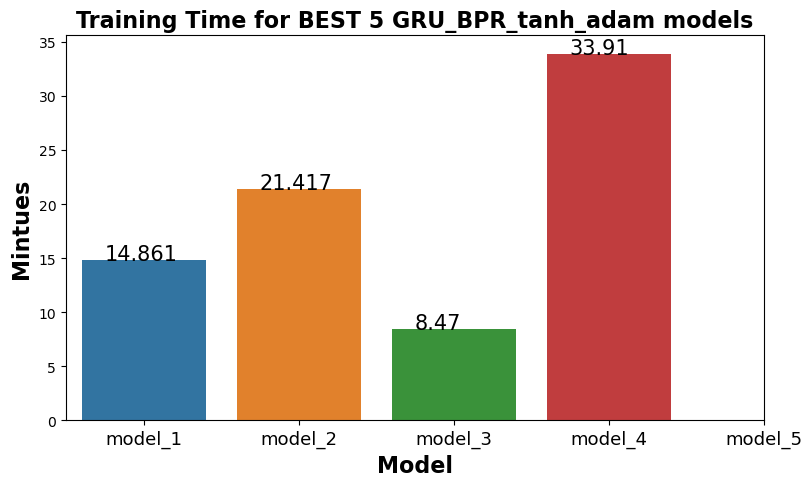

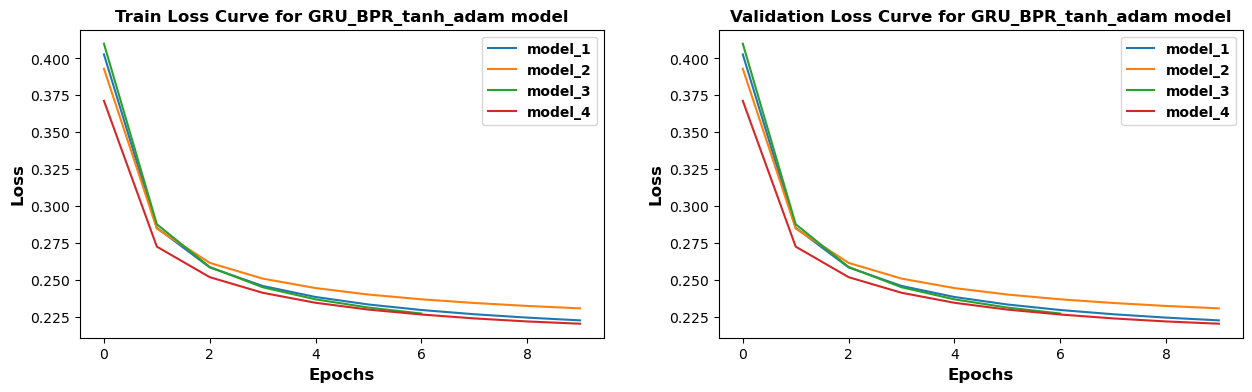

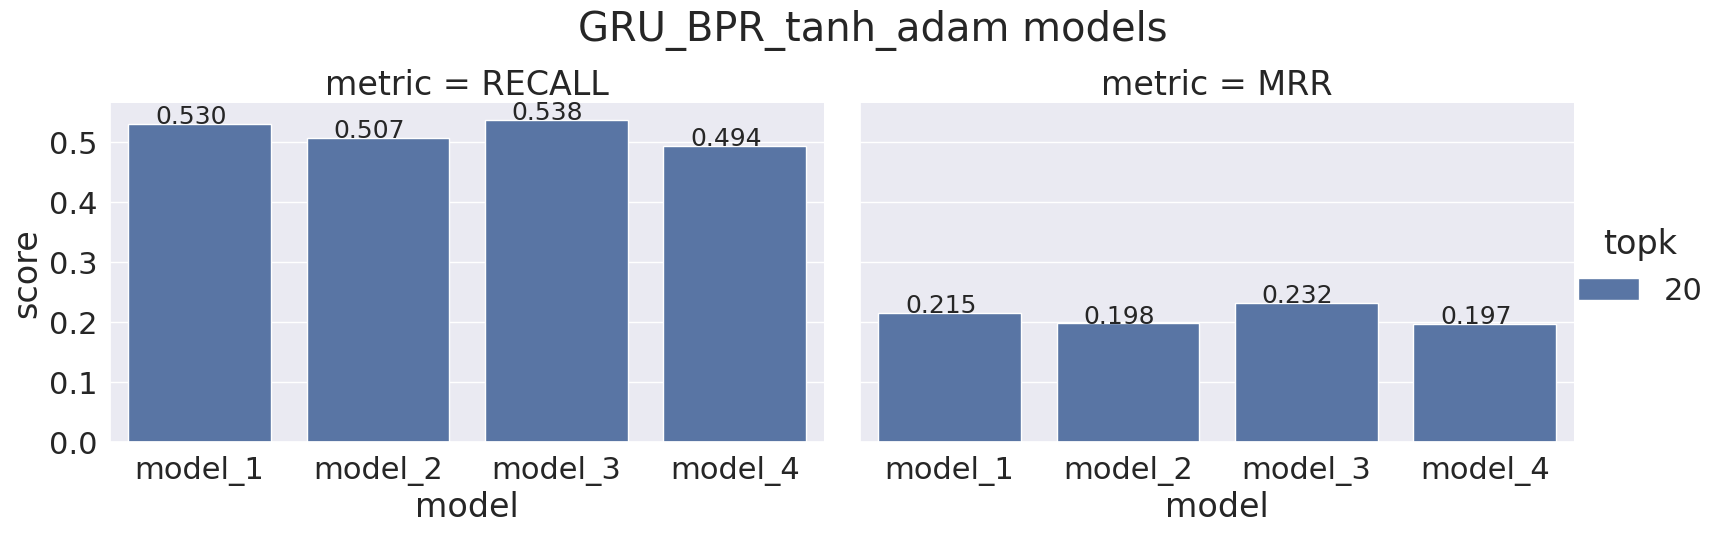

In [25]:
name_model = 'GRU_BPR_tanh_adam'
df = results_gru[results_gru.model.apply(lambda x: x[0:-2]) == name_model]
df.model = df.model.apply(lambda x: 'model_'+str(x[-1]))
#TIME EVALUATION
plt.figure(figsize=(9,5))
ax = sns.barplot(x='model', y='score',data =df[df.metric =='TIME'])
for i,p in enumerate(ax.patches):
    value = '{:.3f}'.format(p.get_height())
    if i>1:
        value = '{:.2f}'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.25
    y = p.get_y() + p.get_height()
    ax.annotate(value, (x, y), size = 15)
plt.xticks(ticks = np.arange(5),labels=[f'model_{i}' for i in range(1,6)],fontsize = 13)
plt.title(f"Training Time for BEST 5 {name_model} models",fontsize = 16,weight = 'bold')
plt.xlabel('Model',fontsize = 16,weight = 'bold')
plt.ylabel('Mintues',fontsize = 16,weight = 'bold')
plt.show()

#LOSS EVALUATION
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,4))
for nll,(name,scores) in df[df.metric=='LOSS'][['model','score']].iterrows():
    ax[0].plot(scores,label=name) 
ax[0].set_title(f"Train Loss Curve for {name_model } model",fontsize = 12,weight="bold")
ax[0].set_xlabel("Epochs",fontsize = 12,weight="bold")
ax[0].set_ylabel("Loss",fontsize = 12,weight="bold")
ax[0].legend(prop={'weight':'bold'})    
for nll,(name,scores) in df[df.metric=='LOSS'][['model','score']].iterrows():
    ax[1].plot(scores,label=name) 
ax[1].set_title(f"Validation Loss Curve for {name_model } model",fontsize = 12,weight="bold")
ax[1].set_xlabel("Epochs",fontsize = 12,weight="bold")
ax[1].set_ylabel("Loss",fontsize = 12,weight="bold")
ax[1].legend(prop={'weight':'bold'})  
fig.subplots_adjust(wspace= 0.22)

#METRICS EVALUATION
sns.set(font_scale = 2)
ax = sns.catplot(x='model', y='score',hue="topk",col="metric", data = df[df.topk !=0], kind="bar",height=5.2,aspect=1.52)
for i in range(2):
    axx = ax.facet_axis(0,i)
    for p in axx.patches:
        value = '{:.3f}'.format(p.get_height())
        x = p.get_x() + p.get_width() / 2 - 0.25
        y = p.get_y() + p.get_height()
        axx.annotate(value, (x, y), size = 18)
ax.fig.subplots_adjust(top=0.80) 
ax.fig.suptitle(f'{name_model } models')
plt.style.use('default')
df = results_gru[results_gru.model.apply(lambda x: x[0:-2]) == name_model]

The model with best Recall and MRR is model 3

In [26]:
df[df.model == name_model+'_3']

,model,topk,metric,score,units,batch_size,dropout,lr
130,GRU_BPR_tanh_adam_3,0,TIME,8.469124,50,64,0,0.001
131,GRU_BPR_tanh_adam_3,20,RECALL,0.537778,50,64,0,0.001
132,GRU_BPR_tanh_adam_3,20,MRR,0.232247,50,64,0,0.001
133,GRU_BPR_tanh_adam_3,0,LOSS,"[0.4099749235728606, 0.28760458557123936, 0.25...",50,64,0,0.001
134,GRU_BPR_tanh_adam_3,0,VAL,"[0.37234160516232884, 0.3212046636821696, 0.30...",50,64,0,0.001


In [27]:
tanh_adam =torch.load('checkpoint/model_BPR_tanh_adam_3_final.pt')
print(tanh_adam['model'])
print(tanh_adam['args'])

GRU4REC(
  (h2o): Linear(in_features=50, out_features=18101, bias=True)
  (final_activation): Tanh()
  (gru): GRU(18101, 50)
)
Namespace(batch_size=64, checkpoint_dir='checkpoint/02121130', cuda=True, data_folder='data/', dropout_hidden=0, dropout_input=0, embedding_dim=-1, eps=1e-06, f='C:\\Users\\Gil zeevi\\AppData\\Roaming\\jupyter\\runtime\\kernel-03fd1012-5c0b-4919-8c55-a731fd28d6e1.json', final_act='tanh', hidden_size=50, k_eval=20, load_model=None, loss_type='BPR', lr=0.001, model_name='BPR_tanh_adam_3', momentum=0, n_epochs=7, num_layers=1, optimizer_type='Adam', save_dir='models/', seed=22, sigma=None, test_data='test_samp.txt', time_sort=False, train_data='train_samp_tr.txt', valid_data='train_samp_valid.txt', weight_decay=0)


## Now lets Load the full results of training and hyperparameters

In [28]:
results_gru = pd.DataFrame(columns = ['model', 'topk','metric','score','units','batch_size','dropout','lr'],dtype=object)
for name in ['model_BPR_leaky_rmsprop','model_BPR_leaky_adagrad','model_BPR_leaky_adam','model_BPR_tanh_adagrad',
            'model_BPR_tanh_rmsprop','model_BPR_tanh_adam']:
    for i in range(5):
        if name.split('_')[-1] == 'adam' and i==4:
            break
        mod = torch.load(f'checkpoint/{name}_{str(i+1)}_final.pt')
        mod_name = "_".join(['GRU']+name.split('_')[1::])+f'_{i+1}'
        #add Time
        timefit = sum(mod['model'].train_time)/60
        results_gru.loc[-1] = [mod_name,0,'TIME',timefit, mod['args'].hidden_size,mod['args'].batch_size,mod['args'].dropout_input,mod['args'].lr]
        results_gru.reset_index(drop = True,inplace = True) 
        #add Recall   
        results_gru.loc[-1] = [mod_name,20,'RECALL',mod['model'].recall,
                               mod['args'].hidden_size,
                               mod['args'].batch_size,
                               mod['args'].dropout_input,
                               mod['args'].lr] ; results_gru.reset_index(drop = True,inplace = True) 
        #add MRR   
        results_gru.loc[-1] = [mod_name,20,'MRR',mod['model'].mrr,
                               mod['args'].hidden_size,
                               mod['args'].batch_size,
                               mod['args'].dropout_input,
                               mod['args'].lr] ; results_gru.reset_index(drop = True,inplace = True) 
        #add LOSS  
        results_gru.loc[-1] = [mod_name,0,'LOSS',mod['model'].train_loss,
                               mod['args'].hidden_size,
                               mod['args'].batch_size,
                               mod['args'].dropout_input,
                               mod['args'].lr] ; results_gru.reset_index(drop = True,inplace = True) 
        #add VAL_LOSS  
        results_gru.loc[-1] = [mod_name,0,'VAL',mod['model'].val_loss,
                               mod['args'].hidden_size,
                               mod['args'].batch_size,
                               mod['args'].dropout_input,
                               mod['args'].lr] ; results_gru.reset_index(drop = True,inplace = True) 

In [29]:
with pd.option_context("display.max_rows", 1000):
    display(results_gru)

,model,topk,metric,score,units,batch_size,dropout,lr
0,GRU_BPR_leaky_rmsprop_1,0,TIME,13.048587,50,50,0,0.001
1,GRU_BPR_leaky_rmsprop_1,20,RECALL,0.520373,50,50,0,0.001
2,GRU_BPR_leaky_rmsprop_1,20,MRR,0.218964,50,50,0,0.001
3,GRU_BPR_leaky_rmsprop_1,0,LOSS,"[0.3581912878004998, 0.21005761228139175, 0.17...",50,50,0,0.001
4,GRU_BPR_leaky_rmsprop_1,0,VAL,"[0.3922467080154113, 0.28588124310980645, 0.24...",50,50,0,0.001
5,GRU_BPR_leaky_rmsprop_2,0,TIME,10.533369,50,64,0,0.001
6,GRU_BPR_leaky_rmsprop_2,20,RECALL,0.526858,50,64,0,0.001
7,GRU_BPR_leaky_rmsprop_2,20,MRR,0.221716,50,64,0,0.001
8,GRU_BPR_leaky_rmsprop_2,0,LOSS,"[0.36397859520075565, 0.21018662468573918, 0.1...",50,64,0,0.001
9,GRU_BPR_leaky_rmsprop_2,0,VAL,"[0.40237834920342164, 0.28989179230173917, 0.2...",50,64,0,0.001


# Best models comparisons:
we'll now present the best models and provide some conclusions

In [30]:
m1=  results_gru['model']== 'GRU_' +paper_model['args'].model_name
m2 = results_gru['model']== 'GRU_' +leaky_adagrad['args'].model_name
m3 = results_gru['model']== 'GRU_' +leaky_adam['args'].model_name
m4 = results_gru['model']== 'GRU_' +leaky_rms['args'].model_name
m5 = results_gru['model']== 'GRU_' +tanh_rms['args'].model_name
m6 = results_gru['model']== 'GRU_' +tanh_adam['args'].model_name
best_models = results_gru[m1|m2|m3|m4|m5|m6].reset_index(drop=True)

In [31]:
best_models['model']=best_models['model'].apply(lambda x: x[8:-2])

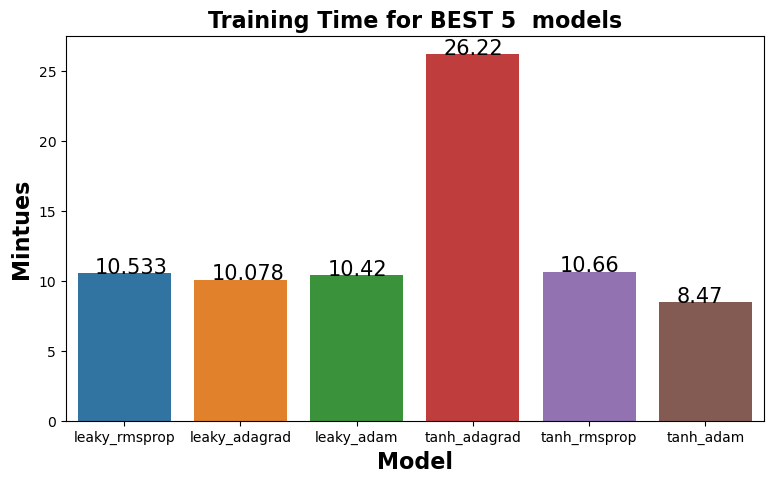

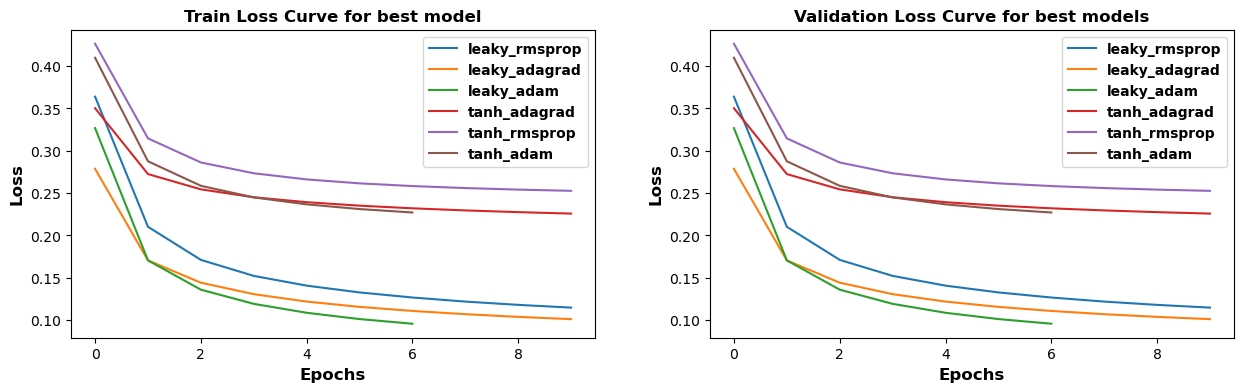

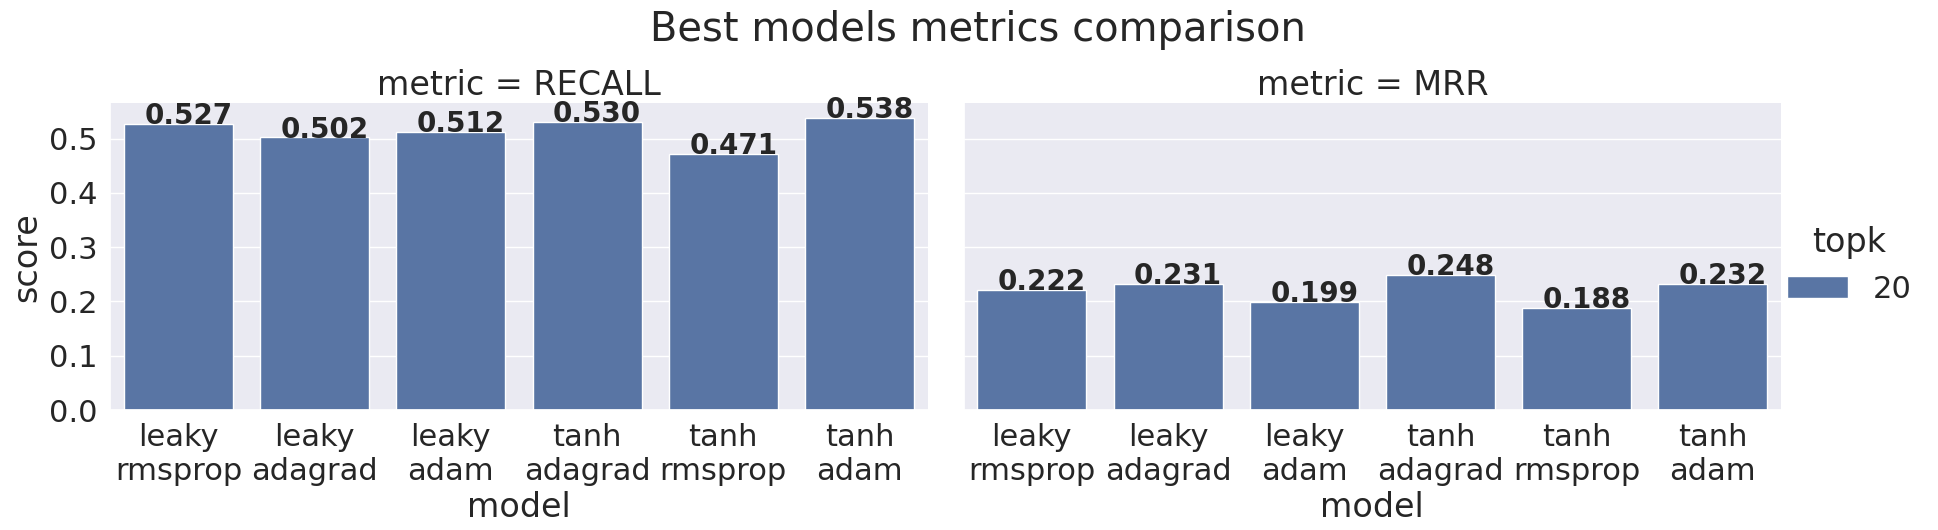

In [32]:
#TIME EVALUATION
plt.figure(figsize=(9,5))
ax = sns.barplot(x='model', y='score',data =best_models[best_models.metric =='TIME'])
for i,p in enumerate(ax.patches):
    value = '{:.3f}'.format(p.get_height())
    if i>1:
        value = '{:.2f}'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.25
    y = p.get_y() + p.get_height()
    ax.annotate(value, (x, y), size = 15)
plt.title(f"Training Time for BEST 5  models",fontsize = 16,weight = 'bold')
plt.xlabel('Model',fontsize = 16,weight = 'bold')
plt.ylabel('Mintues',fontsize = 16,weight = 'bold')
plt.show()

#LOSS EVALUATION
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,4))
for nll,(name,scores) in best_models[best_models.metric=='LOSS'][['model','score']].iterrows():
    ax[0].plot(scores,label=name) 
ax[0].set_title(f"Train Loss Curve for best model",fontsize = 12,weight="bold")
ax[0].set_xlabel("Epochs",fontsize = 12,weight="bold")
ax[0].set_ylabel("Loss",fontsize = 12,weight="bold")
ax[0].legend(prop={'weight':'bold'})    
for nll,(name,scores) in best_models[best_models.metric=='LOSS'][['model','score']].iterrows():
    ax[1].plot(scores,label=name) 
ax[1].set_title(f"Validation Loss Curve for best models",fontsize = 12,weight="bold")
ax[1].set_xlabel("Epochs",fontsize = 12,weight="bold")
ax[1].set_ylabel("Loss",fontsize = 12,weight="bold")
ax[1].legend(prop={'weight':'bold'})  
fig.subplots_adjust(wspace= 0.22)
plt.show()

#METRICS EVALUATION
best = best_models[best_models.topk !=0]
best['model']=best['model'].apply(lambda x: x.replace('_','\n'))
sns.set(font_scale = 2)
ax = sns.catplot(x='model', y='score',hue="topk",col="metric", data = best, kind="bar",height=5.2,aspect=1.72)
for i in range(2):
    axx = ax.facet_axis(0,i)
    for p in axx.patches:
        value = '{:.3f}'.format(p.get_height())
        x = p.get_x() + p.get_width() / 2 - 0.25
        y = p.get_y() + p.get_height()
        axx.annotate(value, (x, y), size = 20,weight="bold")
ax.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
ax.fig.suptitle(f'Best models metrics comparison')
plt.style.use('default') 

# GRU models conclusions:

Yes, we've used a smaller dataset of events - only 4.5 days compares to 6 months that the author did.<br>
we didnt have the resources so we've decreased the dataset in order to experiment with different models and settings.<br>
the thinner dataset allowed us' students without resources, whom used local GPU'S, Google's colab GPU and Kaggle's GPU, to<br>
also try and get some insights on GRU, even though its not in a massive scale as presented in paper.<br>
<br>
Nevertheless, we have reached some interesting conclusions on the dataset above:
1. we've managed to beat the model which was used in paper: GRU with BPR as loss,tanh as activation, adagrad as optimizer.<br>
   BPR as loss,tanh as activation, Adam as optimizer yielded better Recall with less than half of the training time!<br>
   Mrr on the otherhand wasnt improved.<br><br>
2. We actually were able to visualize the fact that in the scale we used, most of the GRU models act almost the same <br>(considering the limitation we had) and actually one shouln't immediately choose the best Recall,MRR yielded model but to <br>examine the complete picture. we can see that any other alternative we've provided, actually , all factors included, can<br> give almost the same results, but with less training time.<br><br>
3. We finally conclude that even though it is mentioned that specific model with specific parameters outperformed all others, one should carefully inspect and perform hyperparameters search for the best model.

# General view and comparisons between best gru's and baseline models:

In [33]:
all_results = pd.concat([best_models[best_models.model.str.contains('tanh_a')],results]).fillna(0).reset_index(drop=True)


In [34]:
all_results.loc[all_results['model'].str.contains('tanh_adag'),'model'] = "Paper's\nmodel"
all_results.loc[all_results['model'].str.contains('tanh_adam'),'model'] = "Our\nmodel"

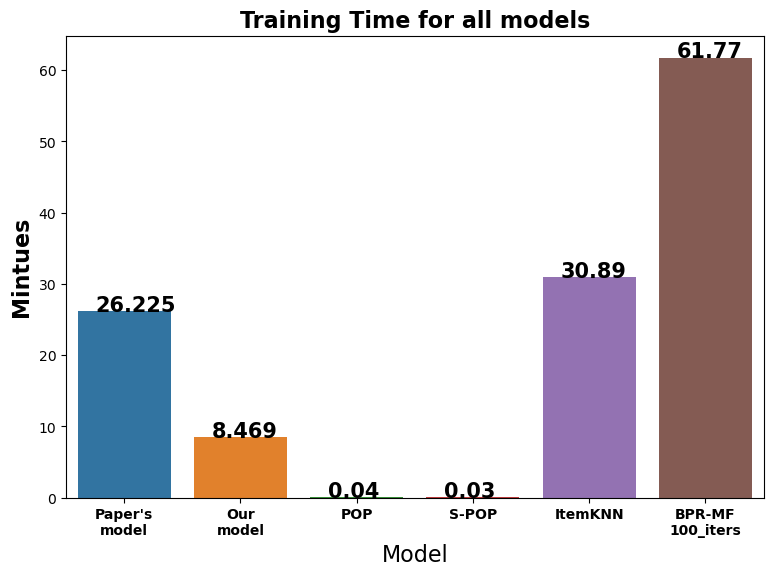

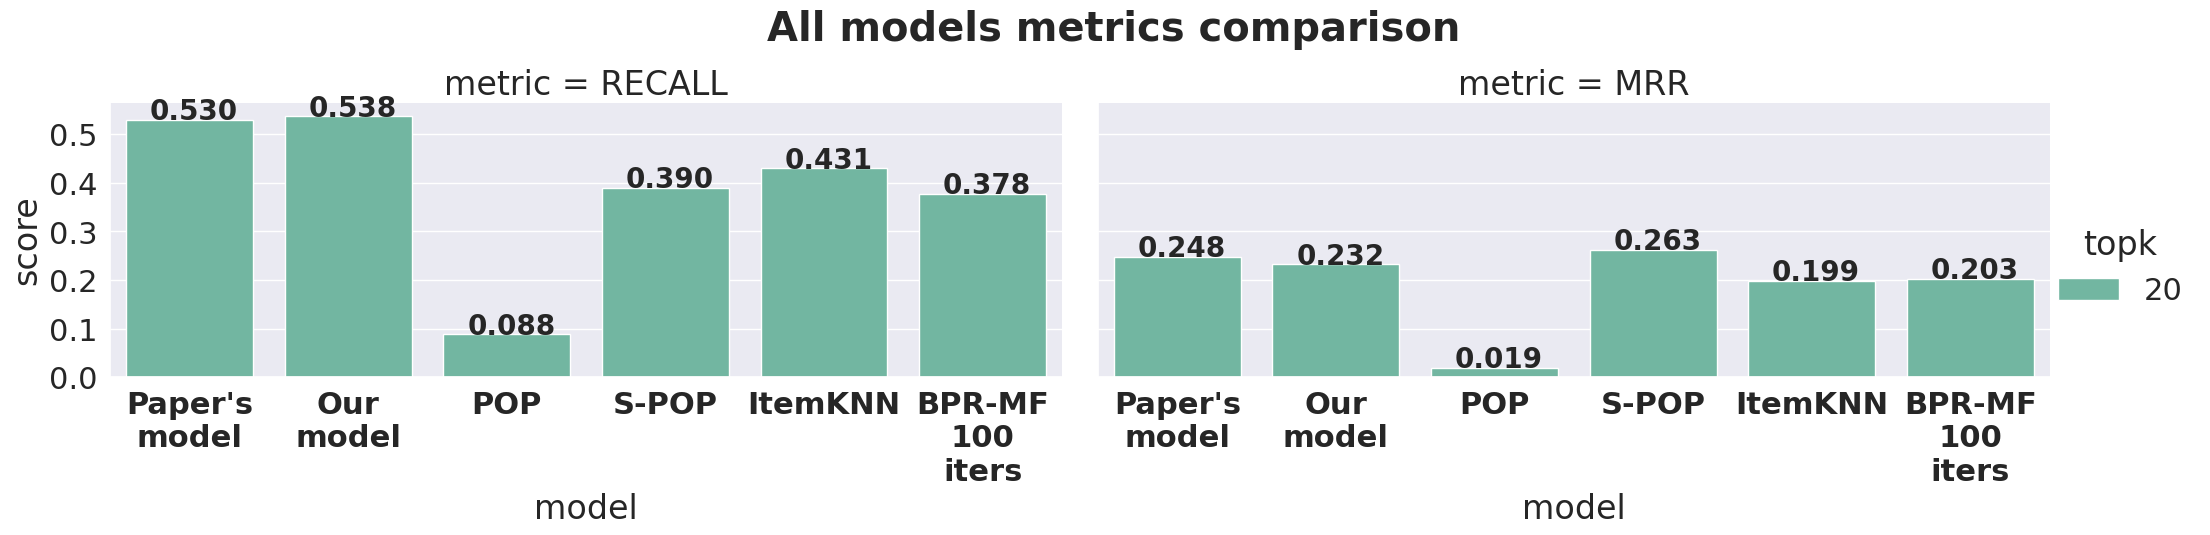

In [35]:
#TIME EVALUATION
plt.figure(figsize=(9,6))
time_all = all_results[all_results.metric =='TIME']
time_all['score']=time_all['score'].apply(lambda x: x/60 if x > 100 else x/1)
ax = sns.barplot(x='model', y='score',data =time_all)
for i,p in enumerate(ax.patches):
    value = '{:.3f}'.format(p.get_height())
    if i>1:
        value = '{:.2f}'.format(p.get_height())
    x = p.get_x() + p.get_width() / 2 - 0.25
    y = p.get_y() + p.get_height()
    ax.annotate(value, (x, y), size = 15,weight="bold")
plt.title(f"Training Time for all models",fontsize = 16,weight = 'bold')
plt.xticks(weight = 'bold')
plt.xlabel('Model',fontsize = 16)
plt.ylabel('Mintues',fontsize = 16,weight = 'bold')
plt.show()
print('\n\n')


#METRICS EVALUATION
best = all_results[all_results.topk !=0]
best['model']=best['model'].apply(lambda x: x.replace('_','\n'))
sns.set(font_scale = 2)
ax = sns.catplot(x='model', y='score',hue="topk",col="metric", data = best, kind="bar",height=5.2,aspect=1.98,palette = sns.color_palette("Set2")
)
for i in range(2):
    axx = ax.facet_axis(0,i)
    for p in axx.patches:
        value = '{:.3f}'.format(p.get_height())
        x = p.get_x() + p.get_width() / 2 - 0.25
        y = p.get_y() + p.get_height()
        axx.annotate(value, (x, y), size = 20,weight="bold")
ax.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
ax.fig.suptitle(f'All models metrics comparison',weight="bold")
ax.set_xticklabels(weight="bold")

plt.style.use('default') 

In [36]:
all_results

,model,topk,metric,score,units,batch_size,dropout,lr
0,Paper's\nmodel,0,TIME,26.224716,100,32,0,0.050
1,Paper's\nmodel,20,RECALL,0.530401,100,32,0,0.050
2,Paper's\nmodel,20,MRR,0.24832,100,32,0,0.050
3,Paper's\nmodel,0,LOSS,"[0.3503511653723741, 0.2724868032425259, 0.254...",100,32,0,0.050
4,Paper's\nmodel,0,VAL,"[0.3576662820194142, 0.33482902270188547, 0.32...",100,32,0,0.050
5,Our\nmodel,0,TIME,8.469124,50,64,0,0.001
6,Our\nmodel,20,RECALL,0.537778,50,64,0,0.001
7,Our\nmodel,20,MRR,0.232247,50,64,0,0.001
8,Our\nmodel,0,LOSS,"[0.4099749235728606, 0.28760458557123936, 0.25...",50,64,0,0.001
9,Our\nmodel,0,VAL,"[0.37234160516232884, 0.3212046636821696, 0.30...",50,64,0,0.001


### <u>conclusions</u>:
 - We worked at a different,smaller, scale as opposed to the GRU4REC paper, we did that in order to 'scale' the RNN network to our available limited resources (colab,local gpu & kaggle). this fact helped us examine a whole bunch of different GRU's with different optimizers and different losses, even though we couldnt afford applying the complete dataset.<br><br>
 - We see that the basic Popularity model fails big time at big scales due to multiple items and too many relevant options.<br><br>
 - We see how a slight change in POP model into per-session popularity model can still be really strong baseline model.<br>Nevertheless we know from the original paper that as the dataset expands - popularity models performance will naturally go down<br><br>
 - Most of our best picked GRU models (performed more than 500 parameters inspections) yielded around the same RECALL@20.<br>
   We thus conclude that as opposed to what's presented in the paper, each GRU model can outperform all the baseline models presented.after careful hyperparameters tuning of course.<br><br>
 - The chosen GRU model in paper had worse training time performance than our pick, even though it had slightly better MRR@20.<br>The RECALL@20 was also in our favor and has beaten the paper model, at our chosen scale of course. Actually having a MRR@20 score of 0.22 or 0.24 doesnt really make significant difference in our opinion.<br><br>
 - We managed to significantly outperform, in term of RECALL@20, the baselines with GRU. futhermore, we know that as the dataset grows bigger, expanding the GRU units even will increase its performance.<br><br>
 - We were surprised by the poor performance of classical MF. it performed poorly on the dataset, compared to the cpu time it took to train. BPR-MF demand many iterations in order to perform well, and at growing and expanding datasets, it becomes not scalable.
 
     
 

### <u>Innovations and improvements added</u>:
 - Choosing a smaller dataset consisting of 4.5 days but still outperforming the baselines with pretty low training time and siginficant higher score in RECALL@20<br><br>
 - Showing training time comparisons between all models.<br><br>
 - Presenting the Validation loss grpahs which were not presented at the original paper. its proves how all the GRU candidates doesnt overfit.<br><br>
 - We questioned the paper's statement which claimed that GRU model with final activation of Tanh and Adagrad optimizer performs the best.<br> we presented all sort of different model which performed almost as the paper's model, but with much less training time. our chosen model even outperformed the paper's model in terms of RECALL@20 and was 3 times faster in terms of training time.

### <u>Future work and inspections</u>:
If we had more time, we would definitely want to inspect multi features session based recommendations.<br>
it can be in adding context or other features to see how the GRU performs. [it is actually also a work of Balázs Hidasi](http://www.hidasi.eu/content/p_rnn_recsys16.pdf) (the author of the original inspected paper).
